## Part I
### Analysis of the reconstructed events 
### Particle $\pi^-$
## Gaus Mean = (Energy, Std=0)
### Constant angle 3$^\circ$
## gps/center -10cm ,0,0


In [1]:
#%matplotlib notebook
import uproot as ur
import matplotlib.pyplot as plt
import k3d
import numpy as np
import awkward as ak
import mplhep as hep
from __future__ import print_function
from scipy.optimize import curve_fit
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.legend_handler import HandlerLine2D
#from scipy.stats import norm
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
from scipy import integrate
import mplhep as hep
import plots
hep.set_style("CMS")

/tmp/ipykernel_1563038/3745656647.py:20: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("CMS")


## Global setting of axis and title size 

In [2]:
params = {'legend.fontsize': '30',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'30',
         'ytick.labelsize':'30',
          
         'axes.labelsize': '30',
         'axes.titlesize': '30'}
hep.set_style("CMS")
plt.rcParams.update(params)

## Local path of the reconstructed file
## Choose particle and sigma for leakage

In [9]:
#### CHOOSE ELECTRON OR PION ('electron' and 'Pion')

particle='Pion'
#particle='electron'


if particle=='Pion':
    FilePathReco="/home/bishnu/EIC/Data/Pion/"
    
elif particle=='electron':
    FilePathReco="/home/bishnu/EIC/Data/electron/"

## PATH WHERE FIGURE ARE SAVED  
PathToPlot='/home/bishnu/UCR_EIC/Plots/'        
Energy_Threshold=0.06 #(Mev)
Time_Threshold=200 #ns
MIP=0.6 #GeV
Gev_To_MeV=1000
Sigma_For_leakage=3
Mean_pions=[]
Mean_electrons=[]



### Defina a function to generate basic Plots 

In [24]:
def energy_distribution_1D(variable,title,energy_plot,particle):
    
    fig,ax = plt.subplots(1,1, figsize=(16, 12),sharex=True,sharey=True)
    #print(len(ene))
    if title=='Energy':
        MinRange=0.0
        MaxRange=800.0
        x_title='Energy (MeV)'
    elif title=='z_pos':
        MinRange=0.0
        MaxRange=150.0
        x_title='Z position (cm)'
    elif title =='y_pos':
        MinRange=0.0
        MaxRange=50.0
        x_title='Y position (cm)'
    elif title =='x_pos':
        MinRange=0.0
        MaxRange=50.0
        x_title='X position (cm)'    
    else: print('PLEASE GIVE RIGHT TITLE')   
    
          
        
    
    ax.hist(ak.flatten(variable),bins=100, range=(MinRange,MaxRange),color='r', linewidth='3')
    #ax.hist(energy,bins=100, range=(MinRange,MaxRange),color='b',histtype='step',linewidth='3')#
    if particle=='Pion':
        greek_particle='$\pi^{-}$'
    elif particle=='electron':
        greek_particle='$e^-$'
    title_plot='{0} GeV {1}'.format(energy_plot,greek_particle)
    
    ax.set_title(title_plot)
    ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.set_xlabel(x_title)
    ax.set_ylabel('Hits')
    print(title)
    FigName='OneD_{0}_{1}GeV_{2}.png'.format(title,energy_plot,particle)
    plt.savefig(f"{PathToPlot}{FigName}")
    #ax.legend(['without cut', 'E>0.06 MeV & time<200 ns'],fontsize='25')
    plt.show() 

### XY Distribution 
def XY_plot2D(X,Y,energy_plot, particle):
    PosRecoX=X
    PosRecoY=Y
    fig,ax = plt.subplots(1,1, figsize=(8, 6),sharex=True,sharey=True)
    hb=ax.hexbin(ak.flatten(PosRecoX),ak.flatten(PosRecoY),gridsize=50, cmap='viridis')

    cb = fig.colorbar(hb, label='hits')
    if particle=='Pion':
        greek_particle='$\pi^{-}$'
    elif particle=='electron':
        greek_particle='$e^-$'
    title='{0} GeV {1}'.format(energy_plot,greek_particle)
    plt.xlabel('position x [cm]')
    plt.title(title)

    plt.ylabel('Position y [cm]')
    FigName='XY_distribution_{0}GeV_{1}.png'.format(energy_plot,particle)
    
    plt.savefig(f"{PathToPlot}{FigName}")
    plt.show()
    
## Particle ID
def ID_Plot(id,particle):
    fig,ax = plt.subplots(1,1, figsize=(8, 6),sharex=True,sharey=True)
    ax.hist(ak.flatten(id),color='r',linewidth='3', bins=51,range=(0,50))
    if particle=='Pion':
        greek_particle='$\pi^{-}$'
    elif particle=='electron':
        greek_particle='$e^-$'
    ax.set_title('MCParticles.PDG ({0})'.format(greek_particle))
    ax.set_xlabel('Particle ID')
    ax.set_yscale('log')
                 
    plt.show()

    
#def gaussian(x, amp, mean, sigma):
#    return amp * np.exp( -(x - mean)**2 / (2*sigma**2) )     
def gaussian(x, amplitude, mean, stddev):
    x_minus_mu_sigma=((x-mean)/stddev)**2
    return (amplitude/stddev) * np.exp(-(0.5*x_minus_mu_sigma))
    

## Plot the Energy of each events and get mean and std deviation of the distribution
def get_resolution(good_energy,energy_plot):
    #fig = plt.figure( figsize=(6, 4))
    fig,ax = plt.subplots(1,1, figsize=(16, 12),sharex=True,sharey=True)
    ene_good=good_energy
    
    ene_total = ak.sum(ene_good,axis=-1)

    ene_average = ak.mean(ene_good,axis=-1)
    #ene_nhits = ak.num(ene_good)
    #HCAL_total=HCAL_total[0:90]

    
    nbins=600
    count, bins,_= plt.hist(np.array(ene_total),bins=nbins,alpha=0.5,range=(0,1200),label='HCAL',linewidth='3',color='b')
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    #print (count)
    
    mean_guess=np.mean(ene_total)
    sigma_guess=np.std(ene_total)
    amplitude_guess=np.max(count)
    
    popt, pcov = curve_fit(gaussian, xdata=binscenters, ydata=count,p0=[amplitude_guess,mean_guess,sigma_guess])
    ax.plot(binscenters, gaussian(binscenters, *popt), color='red', linewidth=2.5, label=r'F')
    ax.set_title("Energy = {0} GeV ".format(energy_plot))
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.set_xlabel("Event energy (MeV)")
    FigName='Fit_SimEnergy_{0}_{1}.png'.format(energy_plot,particle)
    '''
    Nexp = G(t, *popt)
    r = N - Nexp
    chisq = np.sum((r/stdev)**2)
    df = 300 - 2
    print("chisq =",chisq,"df =",df)
    '''
    ### GET MEAN SIGMA AND ERRORS FROM FIT
    mean=popt[1]
    std=popt[2]
    #errors=np.sqrt(np.diag(pcov))
    mean_error=np.sqrt(pcov[1, 1])
    std_error=np.sqrt(pcov[2, 2])
    
    ### GET THE BIN WITH VALUE WHERE IT LIES mEAN -2SIGMA
    two_sig_threshold=mean-(Sigma_For_leakage*std)
    bin_2sig=np.digitize(two_sig_threshold,bins)
   
    ### GET FRACTION OF lEAKAGE
    num_leak=np.sum(count[0:bin_2sig])
    deno_leak=np.sum(count)
    leak_per=(num_leak/deno_leak)*100
    leak_per_error=np.sqrt((np.sqrt(num_leak)/num_leak)**2 + (np.sqrt(deno_leak)/deno_leak)**2)*leak_per
    
    ax.vlines([two_sig_threshold,  two_sig_threshold],0, np.max(count),linestyles='dashed', colors='m', linewidth=5)
   
    #print(two_sig_threshold,  ' leak_per  ',  leak_per, 'val Num       ',val_num/val_deno*100 )
    plt.savefig(f"{PathToPlot}{FigName}")
    plt.show()
    return mean, std, mean_error, std_error, leak_per,leak_per_error



#### Plot for the Resolution, Mean Sigma and Lakage

def plot_resolution(mean, std, mean_error, std_error, resolutions, resolution_errors, leak_per,leak_per_error):
    fig,ax = plt.subplots(1,1, figsize=(16, 12),sharex=True,sharey=True)
    resolutions=np.multiply(resolutions,100)
    print(resolutions)
    resolution_errors=np.multiply(resolution_errors,100)
    ax.errorbar(energies,resolutions, resolution_errors,color="red",marker='o',markersize=20,label='Reconstructed')
    #ax.plot(energies,resolutions, color="blue",marker='*',label="Generated")
    ax.set_xlabel('Energy (GeV)')
    ax.set_ylabel('Resolution (%)')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_ylim(0,30)

    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_major_locator(MultipleLocator(5))   
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_title("Resolution vs Energy")
    FigName="Resolution_Energy_{0}.png".format(particle)
    plt.savefig(f"{PathToPlot}{FigName}")

    plt.show()
    #print(resolutions)
    #print(resolution_errors)
  

    ############ FOR MEAN ################
    fig,ax = plt.subplots(1,1, figsize=(16, 12),sharex=True,sharey=True)
    ax.errorbar(energies,means, mean_error, color="red",marker='o',markersize=20,label='Reconstructed')
    ax.set_xlabel('Energy (GeV)')
    ax.set_ylabel('Mean from fit (GeV)')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    #ax.set_ylim(0,10)

    ax.xaxis.set_major_locator(MultipleLocator(10))
    #ax.yaxis.set_major_locator(MultipleLocator(2))   
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_title("Fitted Mean vs  Energy")
    FigName="MeanE_Energy_{0}.png".format(particle)
    plt.savefig(f"{PathToPlot}{FigName}")

    plt.show()

    print(means,energies)

    ############ FOR SIGMA ################
    fig,ax = plt.subplots(1,1, figsize=(16, 12),sharex=True,sharey=True)
    ax.errorbar(energies,stds, std_error, color="red",marker='o',markersize=20,label='Reconstructed')
    #ax.plot(energies,resolutions, color="blue",marker='*',label="Generated")
    ax.set_xlabel('Energy (GeV)')
    ax.set_ylabel('Sigma (GeV)')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    #ax.set_ylim(0,10)

    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_major_locator(MultipleLocator(20))   
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_title("Fitted sigma vs Energy")
    FigName="Sigma_Energy_{0}.png".format(particle)
    plt.savefig(f"{PathToPlot}{FigName}")
    plt.show()
    
    
    ############### Leakage below 2 Sigma ############
    fig,ax = plt.subplots(1,1, figsize=(16, 12),sharex=True,sharey=True)
    ax.errorbar(energies,leaks_per, leak_per_error,color="red",marker='o',markersize=20,label='Reconstructed')
    #ax.plot(energies,resolutions, color="blue",marker='*',label="Generated")
    ax.set_ylabel('Leakage [%]')
    ax.set_xlabel('Energy (GeV) ')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_ylim(0,20)

    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_major_locator(MultipleLocator(5))   
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_title("Fraction of events below 2$\sigma$)")
    FigName="Leakage_Energy_{0}.png".format(particle)
    plt.savefig(f"{PathToPlot}{FigName}")
    plt.show()
    
    

## Main function Run program for given energy array

rec_cal_outputG0_50_5K_3Deg.edm4hep.root


<Figure size 576x432 with 0 Axes>

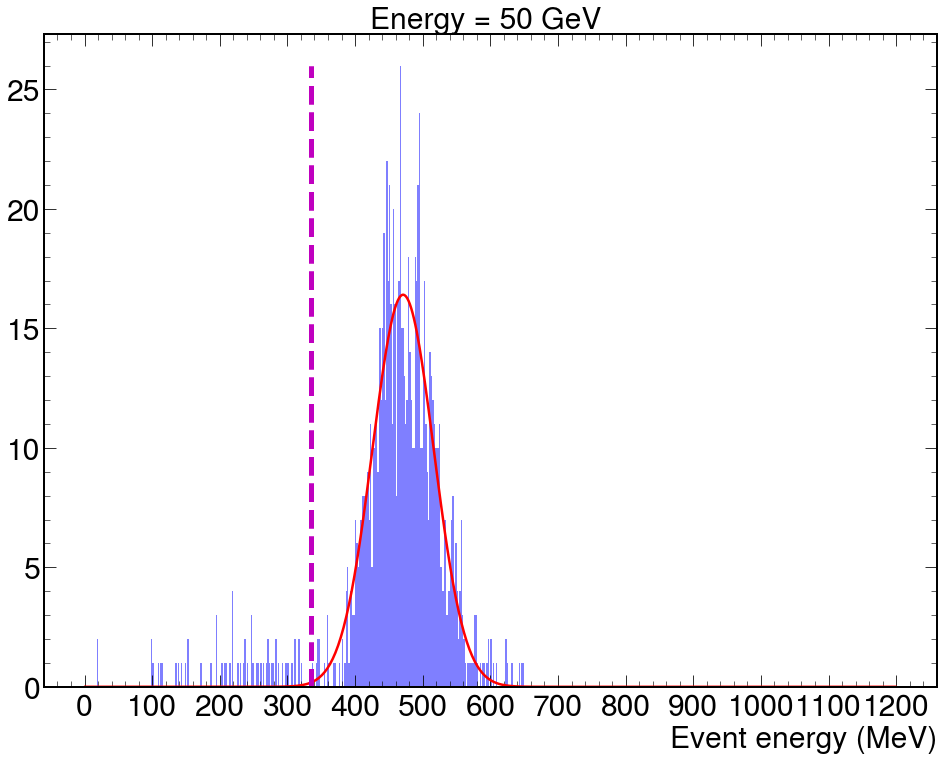

What is your particle
[9.61209235]


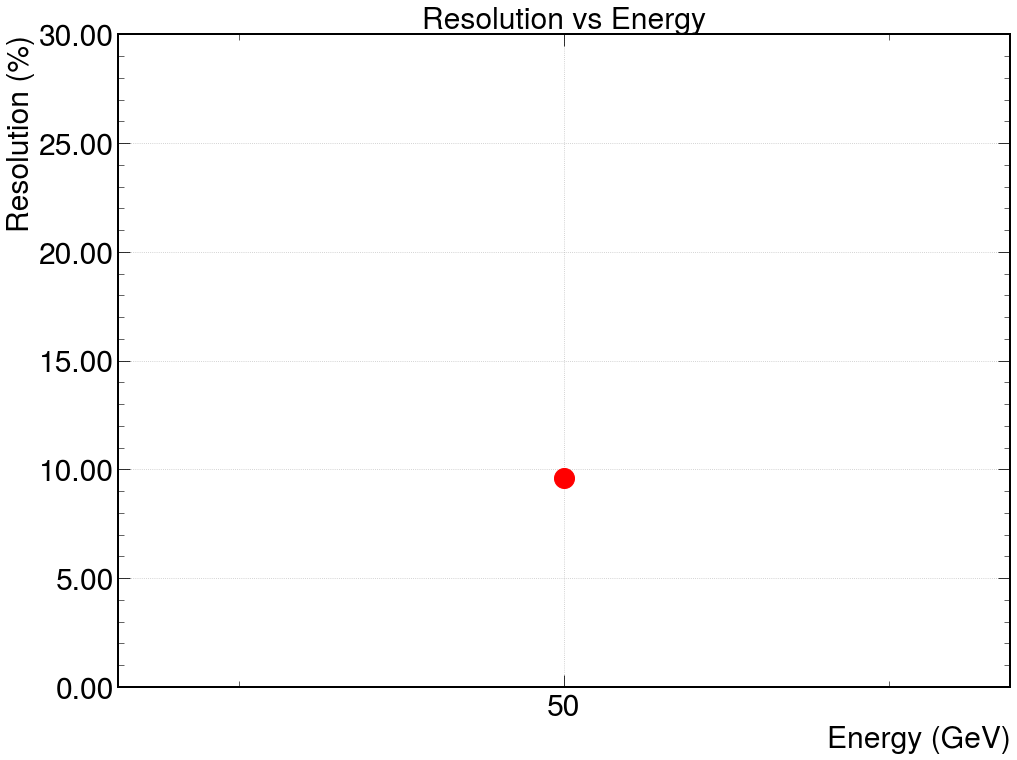

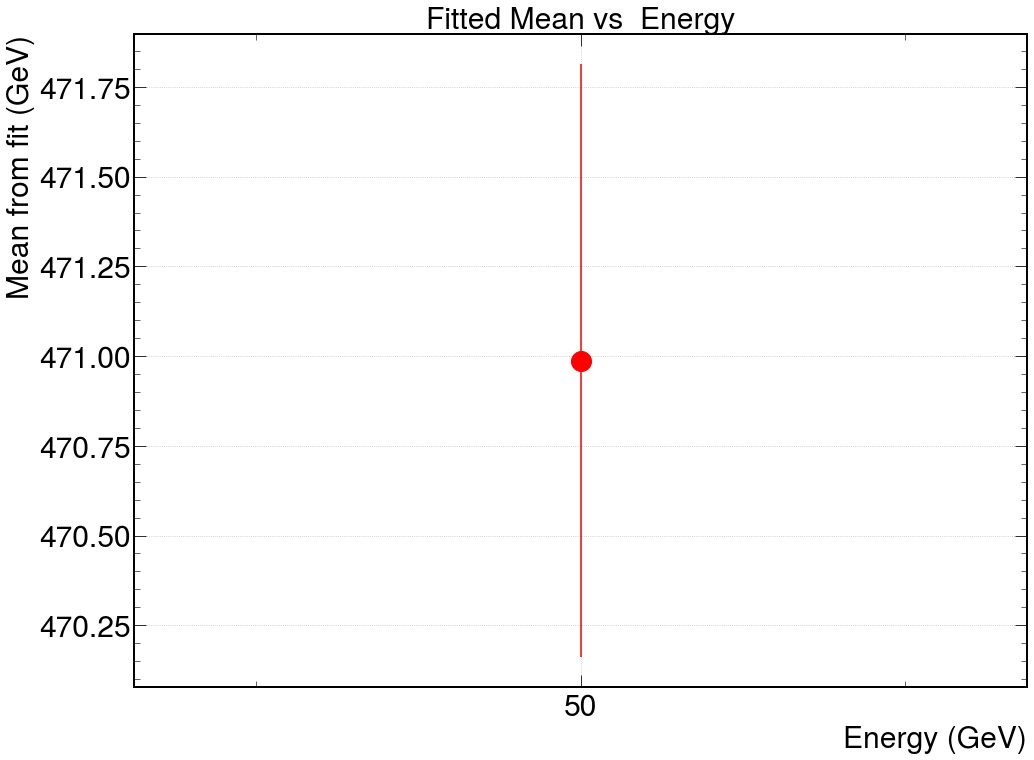

[470.98732834531916] [50]


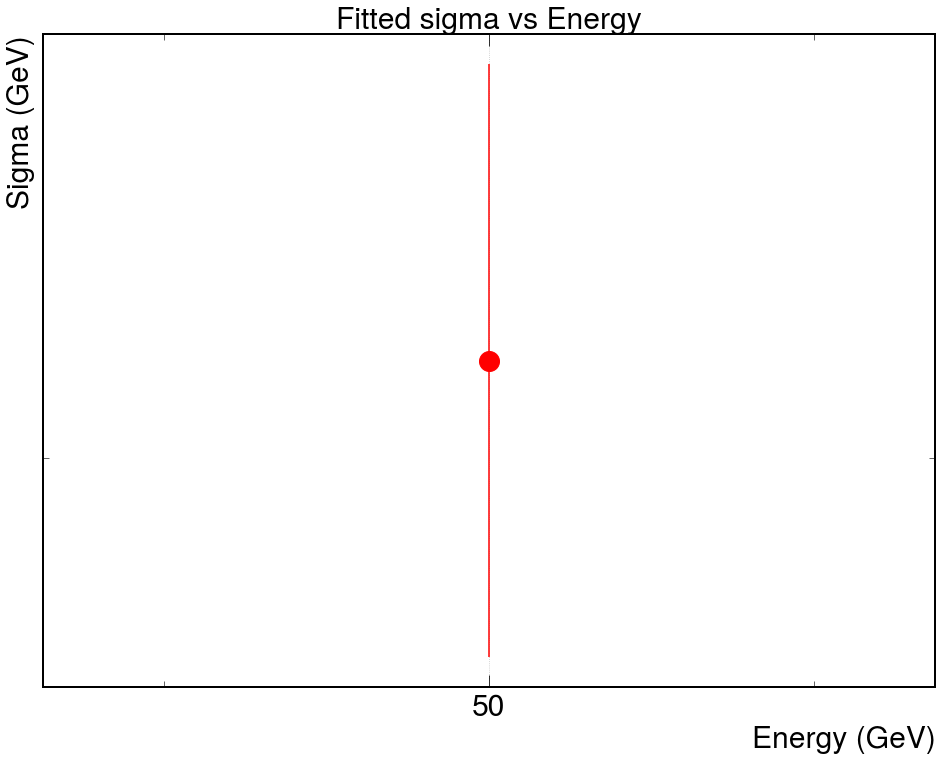

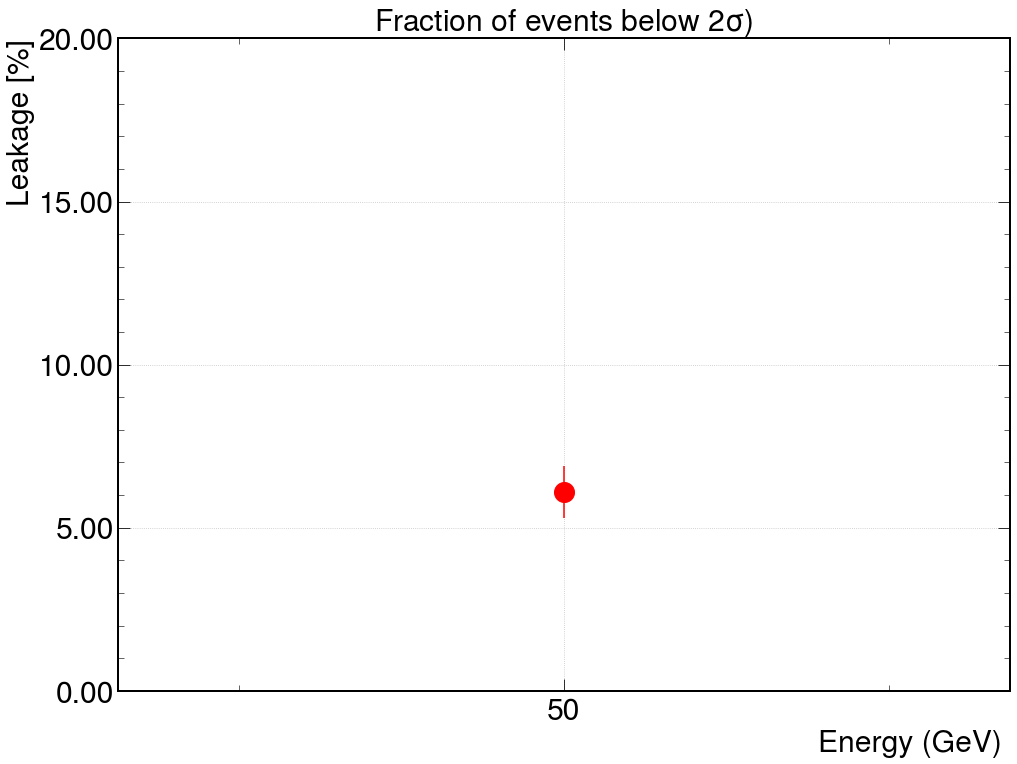

[470.98732834531916] stds    [45.2717369457149]    res    [0.09612092347529677]


In [25]:
#energies=[10,20,30,50,60,80,100]
#events=[5,5,5,5,20,5,5]
energies=[50]



means=[]
stds=[]
resolutions=[]
resolution_errors=[]
means_error=[]
stds_error=[]
leaks_per=[]
leaks_per_error=[]
for ienergy in energies:
    FileName="rec_cal_outputG0_{0}_5K_3Deg.edm4hep.root".format(ienergy)
    
    events=ur.open(f"{FilePathReco}{FileName}:events")
    events.keys()
    arrays = events.arrays()
    #ene = Gev_To_MeV*(ak.flatten(arrays['HcalEndcapPInsertHitsReco.energy'][:])) # in Mev
    ene = Gev_To_MeV*(arrays['HcalEndcapPInsertHitsReco.energy'][:]) # in Mev
    time = (arrays['HcalEndcapPInsertHitsReco.time'][:]) # in ns
    #time = (ak.flatten(arrays['HcalEndcapPInsertHitsReco.time'][:])) # in ns
    PosRecoX = (arrays['HcalEndcapPInsertHitsReco.position.x'])/10.0
    PosRecoY = (arrays['HcalEndcapPInsertHitsReco.position.y'])/10.0
    PosRecoZ= (arrays['HcalEndcapPInsertHitsReco.position.z'])/10.0


    cut_primary = arrays["MCParticles.generatorStatus"]==1
    px = arrays['MCParticles.momentum.x'][cut_primary]
    py = arrays['MCParticles.momentum.y'][cut_primary]
    pz = arrays['MCParticles.momentum.z'][cut_primary]
    mass = arrays["MCParticles.mass"][cut_primary]
    ID=arrays['MCParticles.PDG']#[cut_primary]

    #Calculate generated primary particle properties
    mom = np.sqrt(px**2+py**2+pz**2)
    energy = np.sqrt(mom**2+mass**2)
    fig = plt.figure( figsize=(8, 6))
    phi = np.arctan2(py,px)


    mask=(ene>Energy_Threshold)  & (time<Time_Threshold) & (ene<1e10)
    ene_good=ene[mask]
    
    print(FileName)
    
    ##### For RESOLUTION PLOTS #######
    mean, std, mean_error, sigma_error, leak_per, leak_per_error=get_resolution(ene_good, ienergy)  
      
    #energy_distribution_1D(ene)
    #XY_plot2D(PosRecoX,PosRecoY)
    resolution=(std/mean)
    resolution_error=(np.sqrt((sigma_error/std)**2 + (mean_error/mean)**2))*resolution
    means.append(mean)
    stds.append(std)
    means_error.append(mean_error)
    stds_error.append(sigma_error)
    resolutions.append(resolution)
    resolution_errors.append(resolution_error)
    leaks_per.append(leak_per)
    leaks_per_error.append(leak_per_error)
    #print(means,stds, resolution)
    #print(mean, '  mean error  ', mean_error, '  std  ',  std  , '  sigma_error ',   sigma_error , '  res   ', resolution, ' res err  ', resolution_error)
    #print(stds)
    #print(leak_per)
    
    
    
    ### FOR ONE DIMENSIONAL DISTRIBUTION 
    #SECOND ARGUMENT =Energy  input 'Energy'
    #                  = X/Y/Z pos        '(x/y/z)_pos' 
    
    '''        
    energy_distribution_1D(ene,'Energy',ienergy,particle)
   
    energy_distribution_1D(ene,'x_pos',ienergy,particle)
    energy_distribution_1D(ene,'y_pos',ienergy,particle)
    XY_plot2D(PosRecoX,PosRecoY, ienergy, particle)
    
    '''
    #energy_distribution_1D(ene,'z_pos',ienergy,particle)

    
    
    
if particle=='Pions':
    Mean_pions=means.copy()
elif particle=='electron':
    Mean_electrons=means.copy()
else:
    print("What is your particle")

plot_resolution(mean, std, means_error, stds_error, resolutions, resolution_errors, leaks_per,leaks_per_error)   
    
#print(means, particle)
print(means, 'stds   ', stds, '   res   ',resolutions)


#print(means_error)
#print(resolutions)
#print(resolution_errors) 
#print('Leaks_per_pi =', leaks_per)
#print(leak_per)

#print('Leaks_per_error_pi =', leaks_per_error)
#print(leak_per_error)      
#print(resolutions,resolution_errors)
    

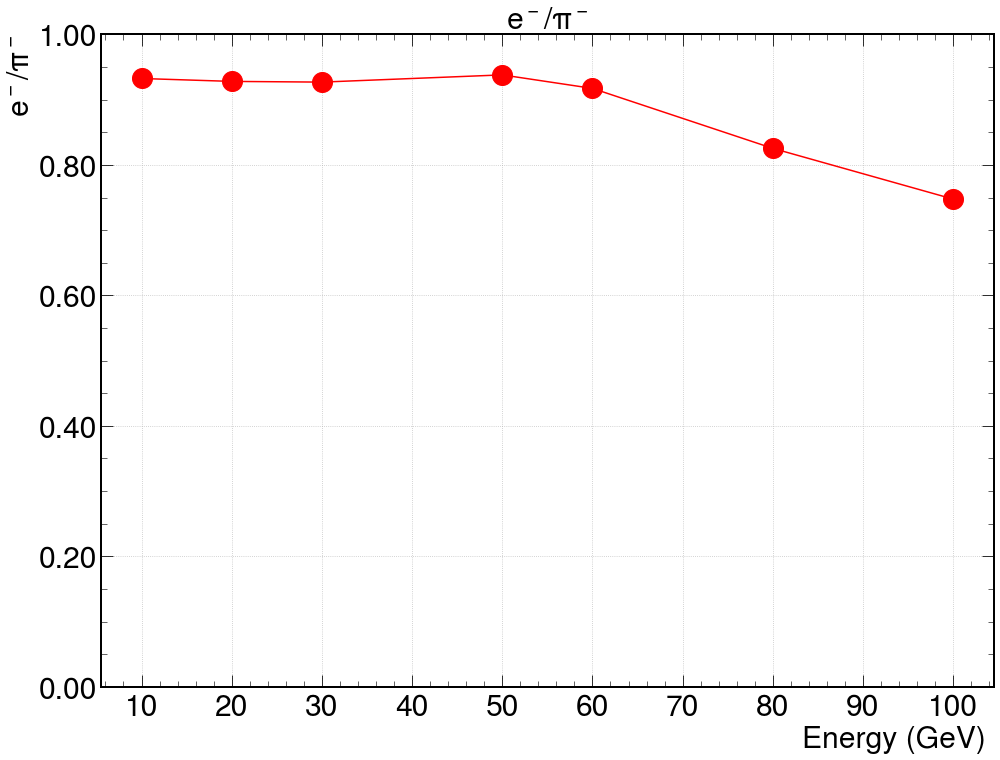

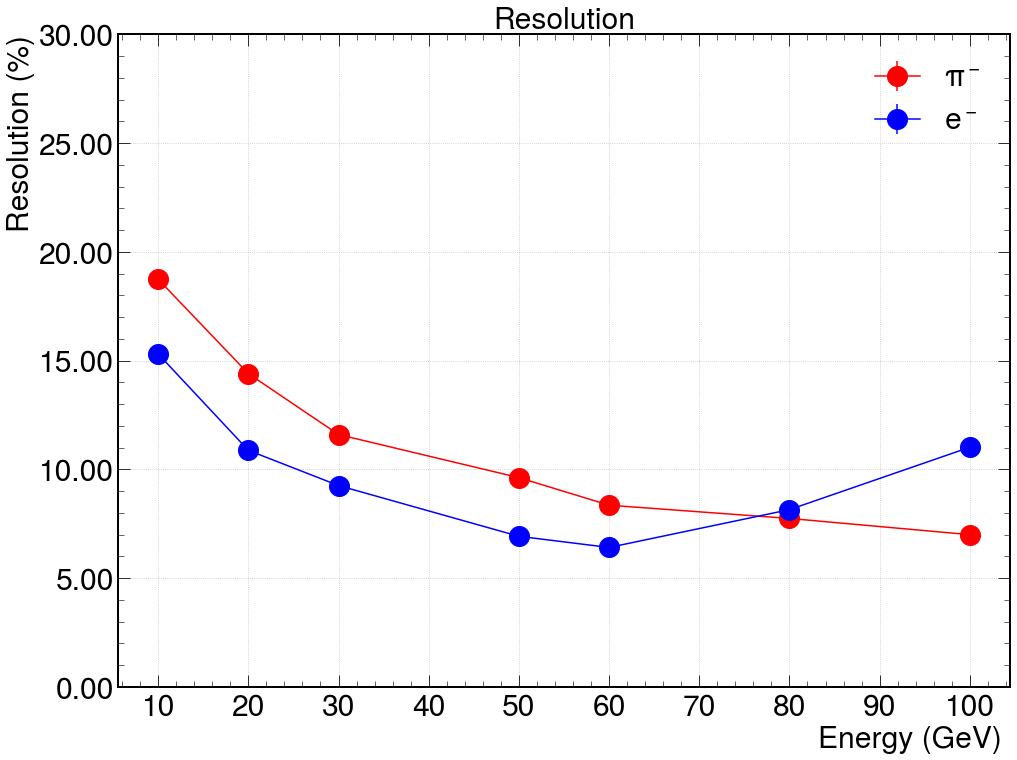

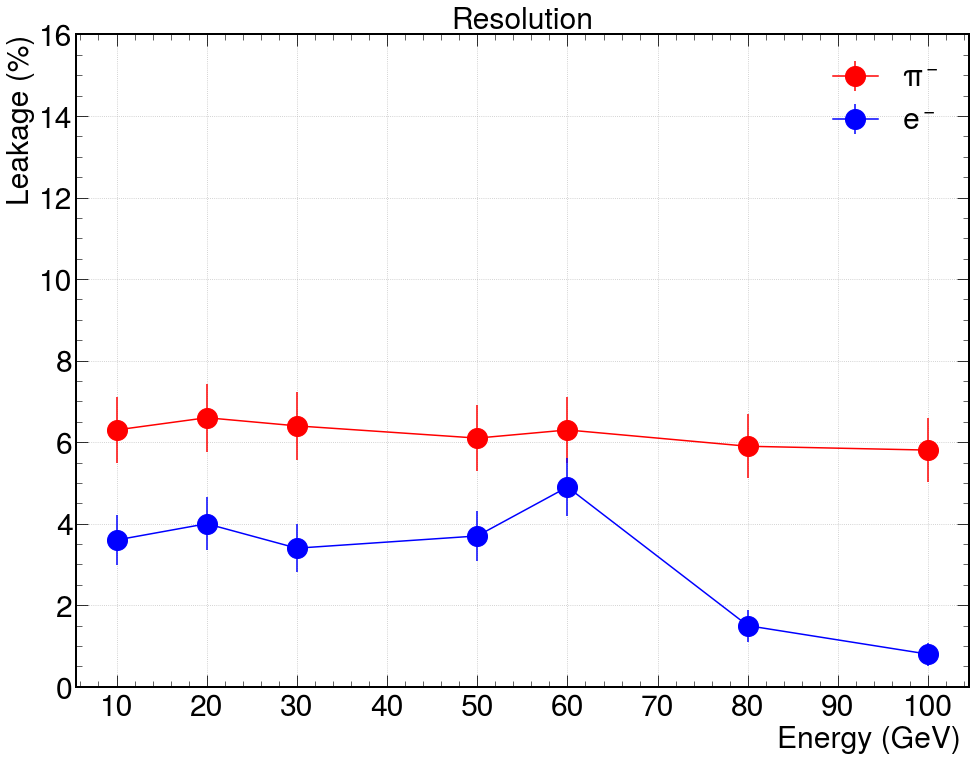

In [8]:
#print(Mean_electrons)
#print(Mean_pions)
energies=[10,20,30,50,60,80,100]
Mean_electrons=[86.66477402461787, 175.99641100765535, 263.8031696761777, 441.7244804861986, 520.6663273875168, 624.7905829101195, 709.8951706836963]
Mean_electrons_error=[0.1079691060727726, 0.2376039483111908, 0.29382967328025816, 0.38191768747015925, 0.5981137221963231, 0.8990715259114447, 2.000913037182325]
Resolution_electron=[0.15308164611255043, 0.10875710604277258, 0.09256091939008847, 0.06921401786169222, 0.06408227805921979, 0.08147395648552981, 0.11016066478424216]
Resolution_electron_err=[0.001260337371726996, 0.0013580107631317106, 0.0011185827942780421, 0.0008666746304209398, 0.0011511029703319972, 0.001443764735977776, 0.00283565436339674]



Mean_pions=[92.93590472573733, 189.63668699714654, 284.58384213131444, 470.89617271784465, 567.5805953691928, 756.9354656556737, 949.5065916671994]
Mean_pions_error=[0.2454727445341804, 0.3871723878233204, 0.5003221027159863, 0.9502002838995046, 0.8690669994485423, 1.19662562766358, 1.6546022407894845]
Resolution_pion=[0.1874258795821687, 0.14404094150972957, 0.1160110856387354, 0.09620338182755339, 0.08351653330553414, 0.07743011618037647, 0.06996469515142344]
Resolution_pion_err= [0.002687304459494411, 0.002062724567094087, 0.0017698743935082545, 0.0020271713885682482, 0.0015365088600021934, 0.0015856138991772529, 0.001746868323825394]


Leaks_per_ele = [3.5999999999999996, 4.0, 3.4000000000000004, 3.6999999999999997, 4.9, 1.5, 0.8]
Leaks_per_error_ele = [0.6107045111999746, 0.644980619863884, 0.5929249530927165, 0.6194271547163557, 0.7169449072278846, 0.3901922603025335, 0.2839718295887816]

Leaks_per_pi = [6.3, 6.6000000000000005, 6.4, 6.1, 6.3, 5.8999999999999995, 5.805805805805806]
Leaks_per_error_pi = [0.8183458926395367, 0.8387848353421754, 0.8252030053265682, 0.80449362955837, 0.8183458926395367, 0.790449239356962, 0.7841574232893603]

Resolution_electron=np.multiply(Resolution_electron,100)
Resolution_electron_err=np.multiply(Resolution_electron_err,100)
Resolution_pion=np.multiply(Resolution_pion,100)
Resolution_pion_err=np.multiply(Resolution_pion_err,100)

ratio=np.divide(Mean_electrons,Mean_pions)
Del_e=np.divide(Mean_electrons_error, Mean_electrons)
Del_p=np.divide(Mean_pions_error, Mean_pions)
abs_delta=np.sqrt((Del_e/Mean_electrons)**2 + (Del_p/Mean_pions)**2) *ratio
############### e/h ############
fig,ax = plt.subplots(1,1, figsize=(16, 12),sharex=True,sharey=True)
ax.errorbar(energies,ratio, abs_delta,color="red",marker='o',markersize=20,label='Reconstructed')

#ax.plot(energies,resolutions, color="blue",marker='*',label="Generated")
ax.set_ylabel('$e^-$/$\pi^-$')
ax.set_xlabel('Energy (GeV) ')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_ylim(0,1)

ax.xaxis.set_major_locator(MultipleLocator(10))
#ax.yaxis.set_major_locator(MultipleLocator(2))   
ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.set_title("$e^-$/$\pi^-$")
FigName="eh_ratio_Energy_{0}.png".format(particle)
plt.savefig(f"{PathToPlot}{FigName}")
plt.show()



fig,ax = plt.subplots(1,1, figsize=(16, 12),sharex=True,sharey=True)
ax.errorbar(energies,Resolution_pion, Resolution_pion_err ,color="red",marker='o',markersize=20,label='$\pi^-$')
ax.errorbar(energies,Resolution_electron, Resolution_electron_err,color="blue",marker='o',markersize=20,label='$e^-$')
#ax.plot(energies,resolutions, color="blue",marker='*',label="Generated")
ax.set_ylabel('Resolution (%)')
ax.set_xlabel('Energy (GeV) ')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_ylim(0,30)

ax.xaxis.set_major_locator(MultipleLocator(10))
#ax.yaxis.set_major_locator(MultipleLocator(2))   
ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.set_title("Resolution")
FigName="Res_e_pi_Energy.png"
plt.legend()
plt.savefig(f"{PathToPlot}{FigName}")
plt.show()


######## Leaks comparision ###########

fig,ax = plt.subplots(1,1, figsize=(16, 12),sharex=True,sharey=True)
ax.errorbar(energies,Leaks_per_pi, Leaks_per_error_pi ,color="red",marker='o',markersize=20,label='$\pi^-$')
ax.errorbar(energies,Leaks_per_ele, Leaks_per_error_ele,color="blue",marker='o',markersize=20,label='$e^-$')

ax.set_ylabel('Leakage (%)')
ax.set_xlabel('Energy (GeV) ')
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_ylim(0,16)

ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(2))   
ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.set_title("Resolution")
FigName="Leakage_e_pi_Energy.png"
plt.legend()
plt.savefig(f"{PathToPlot}{FigName}")
plt.show()


In [171]:
#ID_Plot(ID, particle)
a=20.2468
print("{:.2f}".format(a))     

20.25


## Reconstructed Resolution

In [39]:
list=[2,4,6,8,10]
list1=[2,8,12,16,20] 
np.divide(list1,list)

array([1., 2., 2., 2., 2.])

## simulated Files

[5.64920188 4.32967097 3.29983713 5.54496368 2.2643565  2.87551359
 3.92259364]


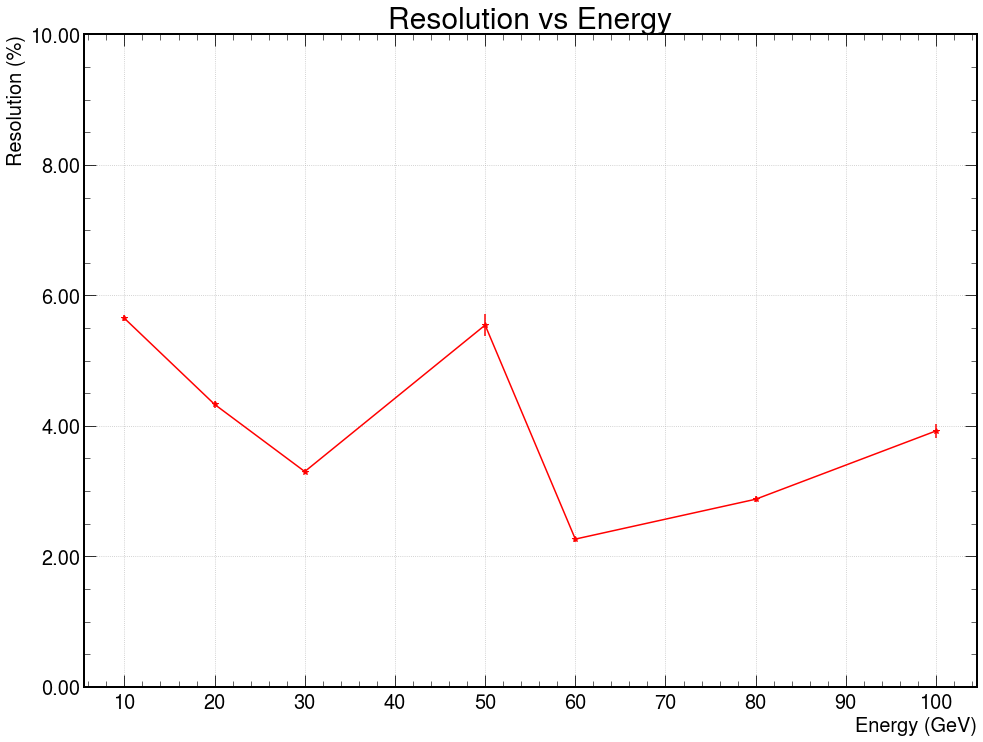

[5.64920188 4.32967097 3.29983713 5.54496368 2.2643565  2.87551359
 3.92259364]
[0.04467932 0.05047074 0.04444642 0.16524928 0.03854935 0.04849922
 0.1090093 ]


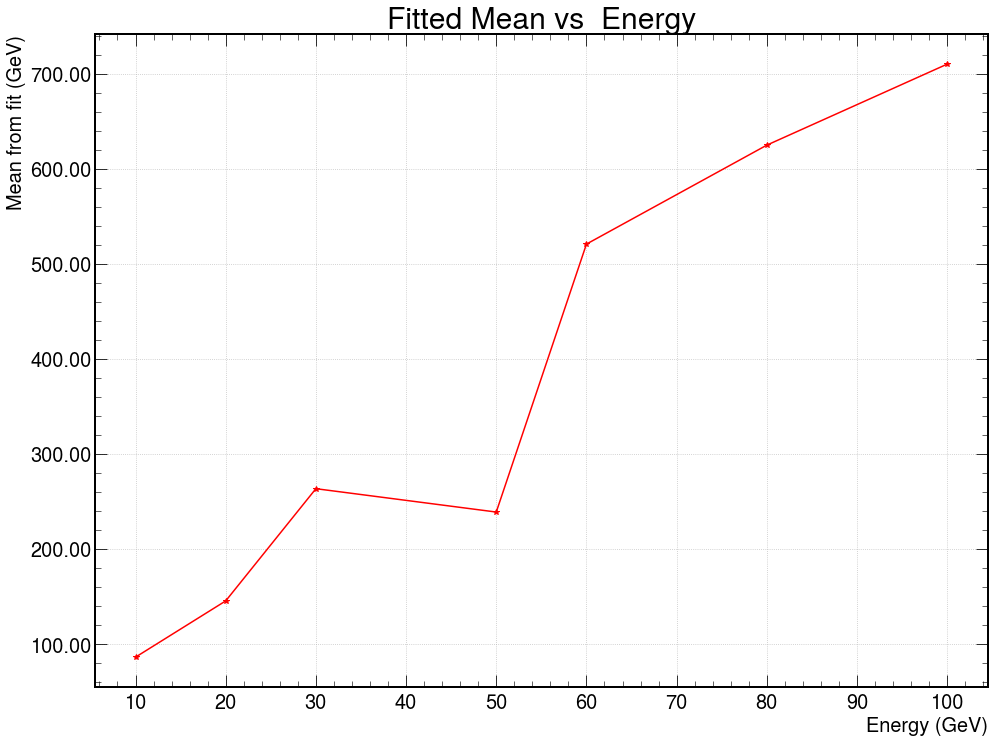

[86.56651215487989, 145.69357087851074, 263.66888330135964, 239.10682982439027, 520.8097816562604, 624.8422495098266, 710.0133771574597] [10, 20, 30, 50, 60, 80, 100]


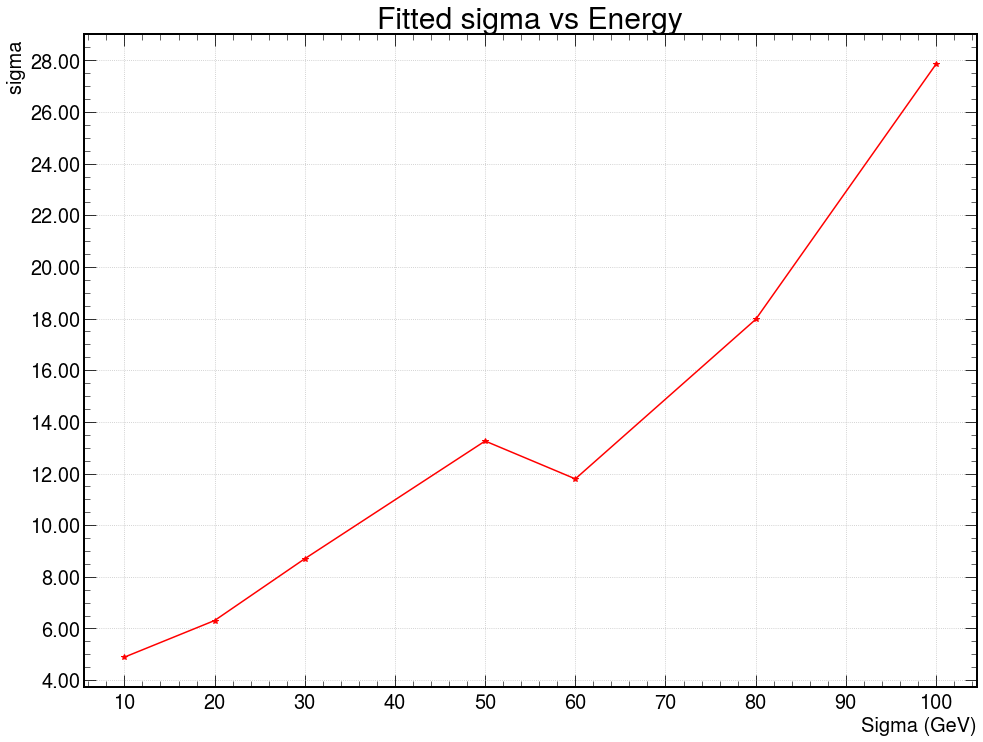

In [ ]:
energies=[80]
events=[5]
means_sim=[]
stds_sim=[]
resolutions_sim=[]
for ienergy,ievent in zip(energies,events):
    FileName_sim="endcapP_insert_simG0_{0}_{1}K_3Deg.root".format(ienergy,ievent)
    
    events=ur.open(f"{FilePathReco}{FileName_sim}:events")
    events.keys()
    arrays = events.arrays()
    #ene = Gev_To_MeV*(ak.flatten(arrays['HcalEndcapPInsertHitsReco.energy'][:])) # in Mev
    ene = Gev_To_MeV*(arrays['HcalEndcapPInsertHits.energy'][:]) # in Mev
    #time = (arrays['HcalEndcapPInsertHits.time'][:]) # in ns
    #time = (ak.flatten(arrays['HcalEndcapPInsertHitsReco.time'][:])) # in ns
    PosRecoX = (arrays['HcalEndcapPInsertHits.position.x'])/10.0
    PosRecoY = (arrays['HcalEndcapPInsertHits.position.y'])/10.
    PosRecoZ= (arrays['HcalEndcapPInsertHits.position.z'])/10.


    cut_primary = arrays["MCParticles.generatorStatus"]==1
    px = arrays['MCParticles.momentum.x'][cut_primary]
    py = arrays['MCParticles.momentum.y'][cut_primary]
    pz = arrays['MCParticles.momentum.z'][cut_primary]
    mass = arrays["MCParticles.mass"][cut_primary]

    #Calculate generated primary particle properties
    mom = np.sqrt(px**2+py**2+pz**2)
    energy = np.sqrt(mom**2+mass**2)
    fig = plt.figure( figsize=(8, 6))
    phi = np.arctan2(py,px)


    mask=(ene>Energy_Threshold)  &  (ene<1e10)#(time<Time_Threshold) &
    ene_good=ene[mask]
    
    #print(FileName)
    
    mean_sim, std_sim=get_resolution(ene_good, ienergy)  
    
    #energy_distribution_1D(ene)
    #XY_plot2D(PosRecoX,PosRecoY)
    resolution_sim=(std_sim/mean_sim)*100
    means_sim.append(mean_sim)
    stds_sim.append(std_sim)
    resolutions_sim.append(resolution_sim)
    
print(means_sim)
print(stds_sim)
print(resolutions_sim)

In [361]:
my_list = [3,2,56,4,32,4,7,88,4,3,4]
bins = [0,20,40,60,80,100]
np.digitize(my_list,bins)

array([1, 1, 3, 1, 2, 1, 1, 5, 1, 1, 1])

## 

In [67]:
FilePathReco="/home/bishnu/EIC/eic_endcap_insert/"
FileName="rec_cal_output.edm4hep.root".format(ienergy,ievent)

events=ur.open(f"{FilePathReco}{FileName}:events")
events.keys()
arrays = events.arrays()
#ene = Gev_To_MeV*(ak.flatten(arrays['HcalEndcapPInsertHitsReco.energy'][:])) # in Mev
ene = Gev_To_MeV*(arrays['HcalEndcapPInsertHitsReco.energy'][:]) # in Mev
time = (arrays['HcalEndcapPInsertHitsReco.time'][:]) # in ns
#time = (ak.flatten(arrays['HcalEndcapPInsertHitsReco.time'][:])) # in ns
PosRecoX = (arrays['HcalEndcapPInsertHitsReco.position.x'])/10.0
PosRecoY = (arrays['HcalEndcapPInsertHitsReco.position.y'])/10.
PosRecoZ= (ak.flatten(arrays['HcalEndcapPInsertHitsReco.position.z']))/10.


cut_primary = arrays["MCParticles.generatorStatus"]==1
px = arrays['MCParticles.momentum.x'][cut_primary]
py = arrays['MCParticles.momentum.y'][cut_primary]
pz = arrays['MCParticles.momentum.z'][cut_primary]
mass = arrays["MCParticles.mass"][cut_primary]

#Calculate generated primary particle properties
mom = np.sqrt(px**2+py**2+pz**2)
energy = np.sqrt(mom**2+mass**2)
fig = plt.figure( figsize=(8, 6))
phi = np.arctan2(py,px)


mask=(ene>Energy_Threshold)  & (time<Time_Threshold) & (ene<1e10)
ene_good=ene[mask]

#print(FileName)
mean, std=get_resolution(ene_good, ienergy)       
#energy_distribution_1D(ene)
#XY_plot2D(PosRecoX,PosRecoY)
resolution=std/mean
means.append(mean)
stds.append(std)
resolutions.append(resolution)
print(means,stds, resolution)

TypeError: cannot unpack non-iterable Figure object

<Figure size 576x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [1]:


fig = plt.figure( figsize=(6, 4))

HCALhits =Gev_To_MeV* arrays['HcalEndcapPInsertHitsReco.energy'][:]
time =arrays['HcalEndcapPInsertHitsReco.time'][:] # in ns
mask =  (HCALhits>Energy_Threshold) & (time<Time_Threshold) &(HCALhits<1e10) 
HCALhits = HCALhits[mask]
HCAL_total = ak.sum(HCALhits,axis=-1)

HCAL_average = ak.mean(HCALhits,axis=-1)
HCAL_nhits = ak.num(HCALhits)
#HCAL_total=HCAL_total[0:90]

mean_guess=np.mean(HCAL_total)
sigma_guess=np.std(HCAL_total)


def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)


count, bins,_= plt.hist(np.array(HCAL_total),bins=bins,alpha=0.5,range=(0,900),label='HCAL',linewidth='3',color='b')
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
print (len(binscenters), len(count), np.max(count))

popt, pcov = curve_fit(gaussian, xdata=binscenters, ydata=count,p0=[100,470,80])
plt.plot(xspace, gaussian(xspace, *popt), color='darkorange', linewidth=2.5, label=r'F')
plt.show()

#xmin, xmax = plt.xlim()

NameError: name 'plt' is not defined

## $\pi^-$ Generated between 10 - 100 GeV, linearly with gradient 0 and intercept 2
##  angle 3 deg total event= 10 K

In [247]:
#FileName="rec_cal_output_10-100GeV_3deg_Lin2.edm4hep.root"
FileName="rec_cal_output_G1_50.edm4hep.root"
events=ur.open(f"{FilePathReco}{FileName}:events")
events.keys()
arrays = events.arrays()

In [317]:
ene = Gev_To_MeV*(ak.flatten(arrays['HcalEndcapPInsertHitsReco.energy'][:])) # in Mev
time = (ak.flatten(arrays['HcalEndcapPInsertHitsReco.time'][:])) # in ns
PosRecoX = (ak.flatten(arrays['HcalEndcapPInsertHitsReco.position.x']))/10.0
PosRecoY = (ak.flatten(arrays['HcalEndcapPInsertHitsReco.position.y']))/10.
PosRecoZ= (ak.flatten(arrays['HcalEndcapPInsertHitsReco.position.z']))/10.


cut_primary = arrays["MCParticles.generatorStatus"]==1
px = arrays['MCParticles.momentum.x'][cut_primary]
py = arrays['MCParticles.momentum.y'][cut_primary]
pz = arrays['MCParticles.momentum.z'][cut_primary]
mass = arrays["MCParticles.mass"][cut_primary]

#Calculate generated primary particle properties
mom = np.sqrt(px**2+py**2+pz**2)
energy = np.sqrt(mom**2+mass**2)
fig = plt.figure( figsize=(8, 6))
phi = np.arctan2(py,px)


mask=(ene>Energy_Threshold)  & (time<Time_Threshold) & (ene<1e10)
ene_good=ene[mask]

<Figure size 576x432 with 0 Axes>

## Plot Energy distribution

930039


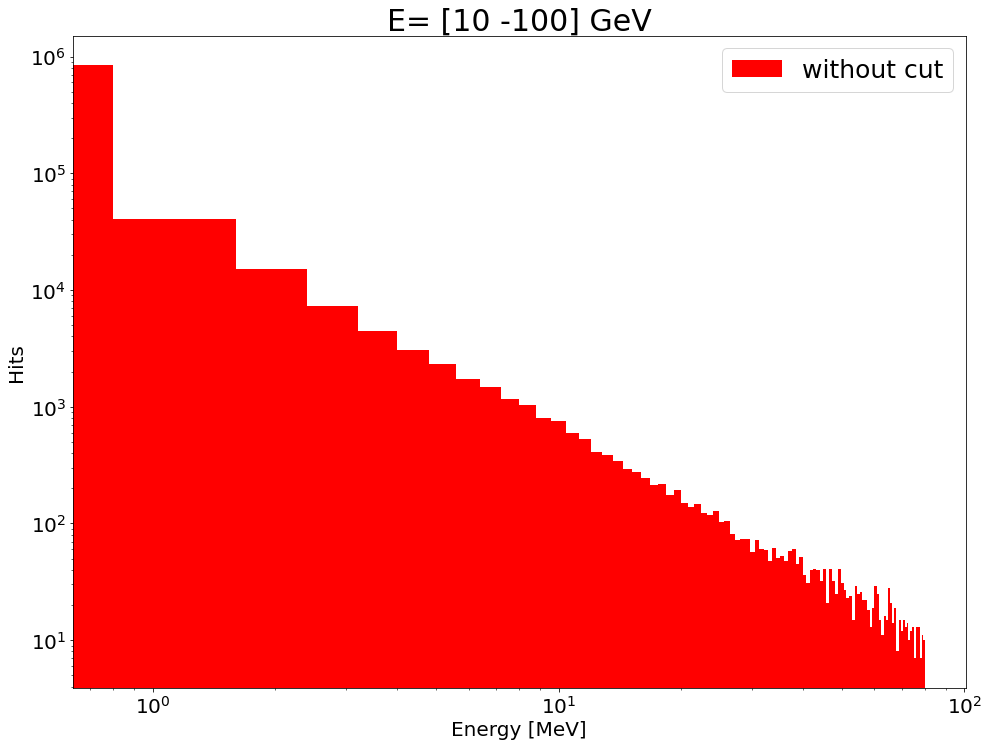

In [318]:
fig,ax = plt.subplots(1,1, figsize=(16, 12),sharex=True,sharey=True)
print(len(ak.flatten(arrays['HcalEndcapPInsertHitsReco.energy'])))
MinRange=0.0
MaxRange=80.0



ax.hist(ene,bins=100, range=(MinRange,MaxRange),color='r', linewidth='3')
#ax.hist(ene_good,bins=100, range=(MinRange,MaxRange),color='b',histtype='step',linewidth='3')#

ax.set_title('E= [10 -100] GeV')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('Hits')
ax.legend(['without cut', 'E>0.06 MeV & time<200 ns'],fontsize='25')
plt.show()

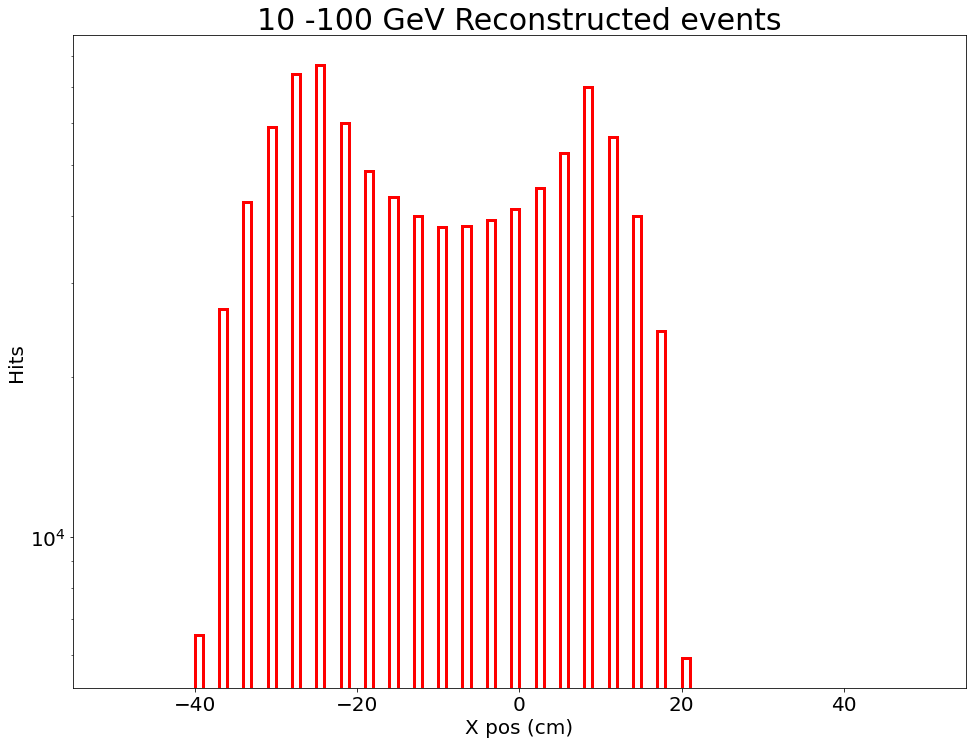

In [272]:
fig,ax = plt.subplots(1,1, figsize=(16, 12),sharex=True,sharey=True)
#ax.hist(ene,bins=100, range=(MinRange,MaxRange),color='r',histtype='step', linewidth='3')
MinRange=-50.0
MaxRange=50.0
#ax.hist(np.array(time),bins=100, range=(MinRange,MaxRange),color='r',histtype='step', linewidth='3')
ax.hist(PosRecoX,bins=100, range=(MinRange,MaxRange),color='r',histtype='step', linewidth='3')
ax.set_title('10 -100 GeV Reconstructed events')
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('X pos (cm)')
ax.set_ylabel('Hits')

#ax.legend(['without cut', 'E>0.06 MeV & time<200 ns'],fontsize='25')
plt.show()

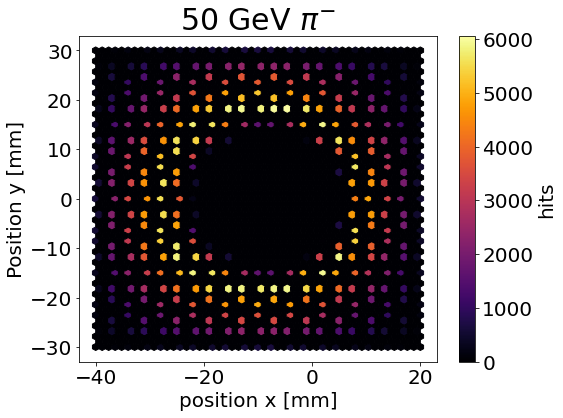

'\nfig = plt.figure( figsize=(12, 8))\nplt.hist(phi,bins=100, range=(-6.0,6.0),color=\'r\',histtype=\'step\', linewidth=\'3\')\nplt.xlabel("$\\phi$( radian)")\n\nplt.show()\n'

In [319]:
fig,ax = plt.subplots(1,1, figsize=(8, 6),sharex=True,sharey=True)
#x50 = ak.flatten(arrays['HcalEndcapPInsertHits.position.x'])
#y50 = ak.flatten(arrays['HcalEndcapPInsertHits.position.y'])


hb=ax.hexbin(np.array(PosRecoX),np.array(PosRecoY),gridsize=50, cmap='inferno')

cb = fig.colorbar(hb, label='hits')

plt.xlabel('position x [mm]')
plt.title("50 GeV $\pi^{-}$")

plt.ylabel('Position y [mm]')
plt.show()
'''
fig = plt.figure( figsize=(12, 8))
plt.hist(phi,bins=100, range=(-6.0,6.0),color='r',histtype='step', linewidth='3')
plt.xlabel("$\phi$( radian)")

plt.show()
'''

## Sum of energy 

90 90 96.0


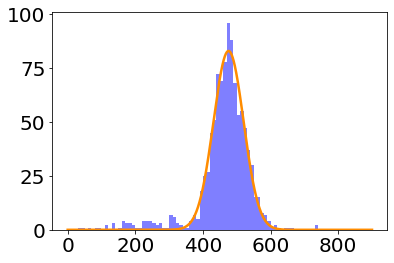

## Resolution plot

/tmp/ipykernel_162872/1950860338.py:9: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


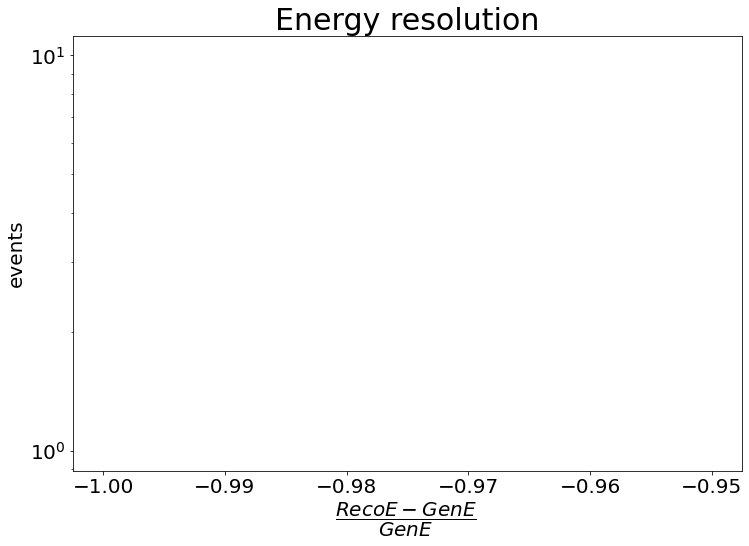

In [316]:
import math
resolution=(HCAL_total - energy)/energy
fig = plt.figure( figsize=(12, 8))
plt.hist(resolution,bins=10,alpha=0.5,range=(-1,-0.95),label='AL',histtype='step',linewidth='3',color='b')
plt.title('Energy resolution')
plt.xlabel('$\dfrac{Reco E - Gen E}{Gen E}$ ')
plt.ylabel('events')
#plt.legend()
plt.yscale('log')
#plt.xscale('log')
plt.show()


## File with Energy =9.9 -10.0 GeV

In [111]:
#FileName10Reco="rec_cal_output_99-100_3deg.edm4hep.root"
FileName10Reco="rec_cal_output_99_100_Ln2.edm4hep.root"
events10Reco=ur.open(f"{FilePathReco}{FileName10Reco}:events")
events10Reco.keys()
arrays10Reco = events10Reco.arrays()
#events50PiM.show()

## File with Energy =49.9 -50.0 GeV

In [110]:
'''
#FileName50Reco="rec_cal_output_499-500_3deg.edm4hep.root"
FileName10Reco="rec_cal_output_499_500_Ln2.edm4hep.root"
events50Reco=ur.open(f"{FilePathReco}{FileName50Reco}:events")
events50Reco.keys()
arrays50Reco = events50Reco.arrays()
'''

'\n#FileName50Reco="rec_cal_output_499-500_3deg.edm4hep.root"\nFileName10Reco="rec_cal_output_499_500_Ln2.edm4hep.root"\nevents50Reco=ur.open(f"{FilePathReco}{FileName50Reco}:events")\nevents50Reco.keys()\narrays50Reco = events50Reco.arrays()\n'

## File with Energy =99.9 -100.0 GeV

In [108]:
'''
FileName100Reco=""
events100Reco=ur.open(f"{FilePathReco}{FileName100Reco}:events")
events100Reco.keys()
arrays100Reco = events100Reco.arrays()
'''

'\nFileName100Reco=""\nevents100Reco=ur.open(f"{FilePathReco}{FileName100Reco}:events")\nevents100Reco.keys()\narrays100Reco = events100Reco.arrays()\n'

## Make a array of variables needed Timing <200 ns  and energy cut >0.06 Mev Selected

In [130]:
ene10 = Gev_To_MeV*(ak.flatten(arrays10Reco['HcalEndcapPInsertHitsReco.energy'][:])) # in Mev
time10 = (ak.flatten(arrays10Reco['HcalEndcapPInsertHitsReco.time'][:])) # in ns
PosRecoX = arrays['HcalEndcapPInsertHitsReco.position.x']
PosRecoY = arrays['HcalEndcapPInsertHitsReco.position.y']
PosRecoZ= arrays['HcalEndcapPInsertHitsReco.position.z']

#Create 1D arrays for reconstructed hit data
RecoEventEnergies = []
RecoHitEnergies = []
RecoTimes = []
RecoXpos = []
RecoYpos = []
RecoZpos = []

#Gather arrays of generated primary particles
cut_primary = arrays["MCParticles.generatorStatus"]==1
px = arrays['MCParticles.momentum.x'][cut_primary]
py = arrays['MCParticles.momentum.y'][cut_primary]
pz = arrays['MCParticles.momentum.z'][cut_primary]
mass = arrays["MCParticles.mass"][cut_primary]

#Calculate generated primary particle properties
mom = np.sqrt(px**2+py**2+pz**2)
energy = np.sqrt(mom**2+mass**2)
fig = plt.figure( figsize=(8, 6))
phi = np.arctan2(py,px)







mask10=(en10>Energy_Threshold) &(en10<1e10) & (time10<Time_Threshold)
ene_good=en10[mask10]

190451


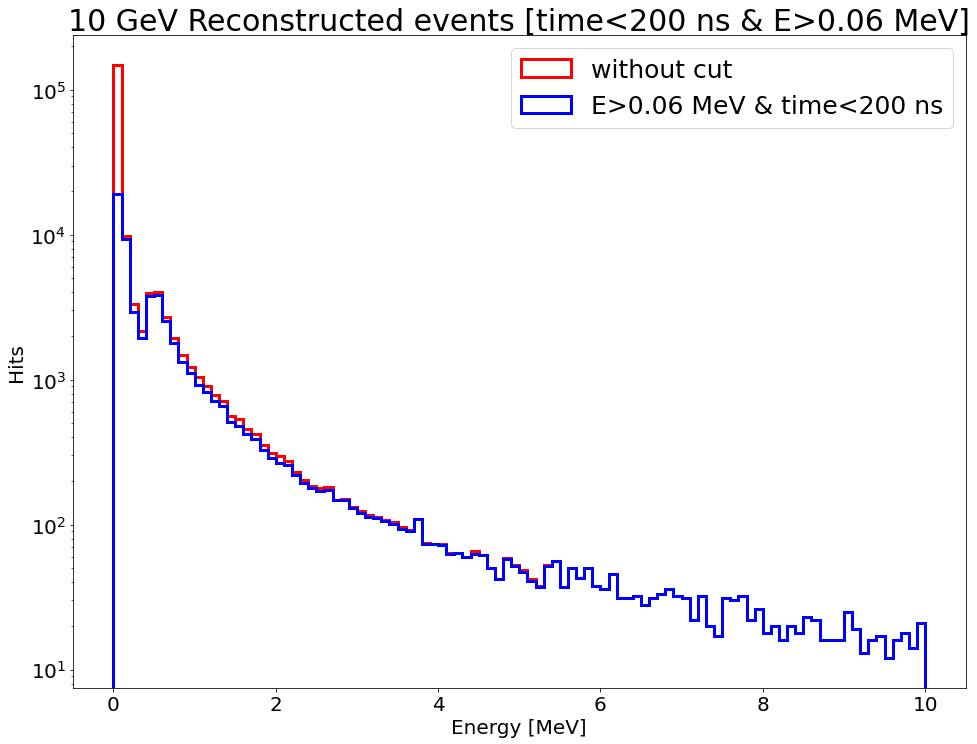

In [151]:
fig,ax = plt.subplots(1,1, figsize=(16, 12),sharex=True,sharey=True)
print(len(ak.flatten(arrays10Reco['HcalEndcapPInsertHitsReco.energy'])))
MinRange=0.0
MaxRange=10.0



ax.hist(ene10,bins=100, range=(MinRange,MaxRange),color='r',histtype='step', linewidth='3')
ax.hist(ene_good,bins=100, range=(MinRange,MaxRange),color='b',histtype='step',linewidth='3')#

ax.set_title('10 GeV Reconstructed events [time<200 ns & E>0.06 MeV]')
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('Hits')
ax.legend(['without cut', 'E>0.06 MeV & time<200 ns'],fontsize='25')
plt.show()


## Time distribution of reconstructed hits

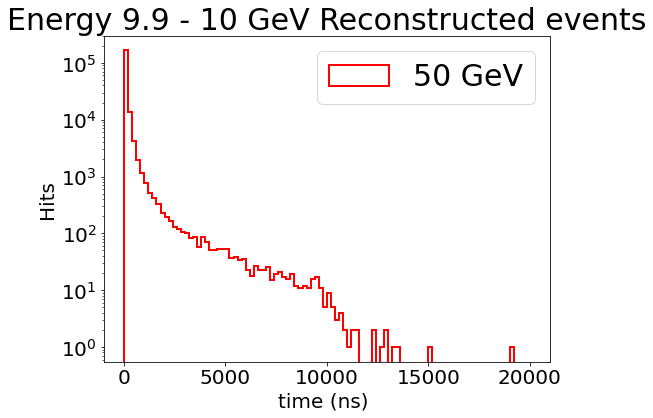

In [135]:
fig,ax = plt.subplots(1,1, figsize=(8, 6),sharex=True,sharey=True)
MinRange=.0
MaxRange=20000.


time10 = (ak.flatten(arrays10Reco['HcalEndcapPInsertHitsReco.time'][:]))
time10test = (ak.flatten(arrays10Reco['HcalEndcapPInsertHitsReco.time'][:,:]))
ax.hist(time10,bins=100, range=(MinRange,MaxRange),label='50 GeV',color='r',histtype='step',linewidth='2')
#ax.hist(time10test,bins=100, range=(MinRange,MaxRange),label='100 GeV',color='g',histtype='step', linewidth='2')


#events50PiM.show()
#ax.hist(ak.flatten(arrays10Reco['HcalEndcapPInsertHits.position.z']),bins=100, range=(MinRange,MaxRange),label='HCAL')

ax.set_title('Energy 9.9 - 10 GeV Reconstructed events')
ax.set_yscale('log')
ax.set_xlabel('time (ns) ')
ax.set_ylabel('Hits')

plt.show()

### Resolution Study

In [152]:
FileName10Gen="endcapP_insert_sim.root"
events10Gen=ur.open(f"{FilePathReco}{FileName10Gen}:events")
events10Gen.keys()
arrays10Gen = events10Gen.arrays()
ene10_sim = Gev_To_MeV*(ak.flatten(arrays10Gen['HcalEndcapPInsertHits.energy'][:])) # in Mev


ValueError: key "HcalEndcapPInsertHits.energy" does not exist (not in record)

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/libawkward/util.cpp#L525)

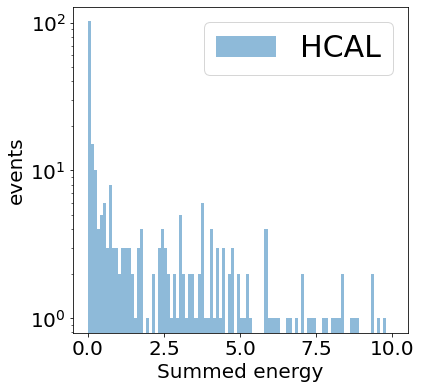

In [126]:
#en =Gev_To_MeV*arrays10Reco['HcalEndcapPInsertHitsReco.energy'][:,:]#B
#en10 = Gev_To_MeV*(ak.flatten(arrays10Reco['HcalEndcapPInsertHitsReco.energy'][:]))
time10 =arrays10Reco['HcalEndcapPInsertHitsReco.time'][:]

HCALhits =Gev_To_MeV*(arrays10Reco['HcalEndcapPInsertHitsReco.energy'][:]) ##C

mask = (HCALhits<1e10) & (HCALhits>Energy_Threshold) & (time10<Time_Threshold)

HCALhits = HCALhits[mask]
HCAL_total = ak.sum(HCALhits,axis=-1)
HCAL_average = ak.mean(HCALhits,axis=-1)
HCAL_nhits = ak.num(HCALhits)

#print('total HCAL energy' , HCAL_total)
#print('Average hit energy in HCAL' , HCAL_average)


fig = plt.figure( figsize=(6, 6))

plt.hist(HCAL_total,bins=100,alpha=0.5,range=(0,10),label='HCAL')

plt.xlabel('Summed energy')
plt.ylabel('events')
plt.legend()
plt.yscale('log')

plt.show()

#np.sum([[0.0839, 0.101], [], [0.105, 0.0931], [0.539, 0.516], [0.658, 0.0809]])

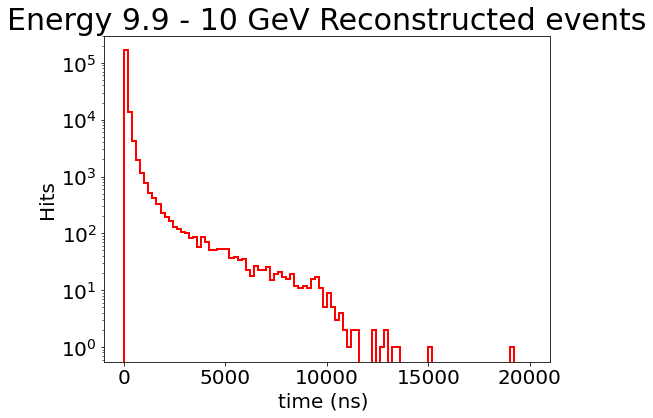

## PART 2 [simulated files]
### This notebook does simple hit analysis Energy, X, Y distributions for pions and muons 
### In gps.mac file for angle setting
### /gps/ang/mintheta 170 degree
### /gps/ang/maxtheta 175 degree
### actually throws particles from 5-10 degrees, as you say


In [61]:
FilePath="/home/bishnu/UCR_EIC/regressiononly/GeneratedFilesFromInsert/"

## Data:  $\pi^-$ Angle [170 -179.9]  &&  Energy [Gaus Mean= 10 GeV and Sigma 1 GeV]
## Data:  $\pi^-$ Angle [170 -179.9]  &&  Energy [Gaus Mean= 50 GeV and Sigma 1 GeV]

In [88]:
FileNamePi10="endcapP_insert_10GeV_170_180_piM.root"
events10PiM=ur.open(f"{FilePath}{FileNamePi10}:events")
events10PiM.keys()
arrays10PiM = events10PiM.arrays()

## Energy 50 GeV data
FileNamePi50="endcapP_insert_50GeV_170_180_piM.root"
events50PiM=ur.open(f"{FilePath}{FileNamePi50}:events")
#events50PiM.show()
events50PiM.keys()
arrays50PiM = events50PiM.arrays()

## One dimensional histograms for Energy

<Figure size 576x432 with 0 Axes>

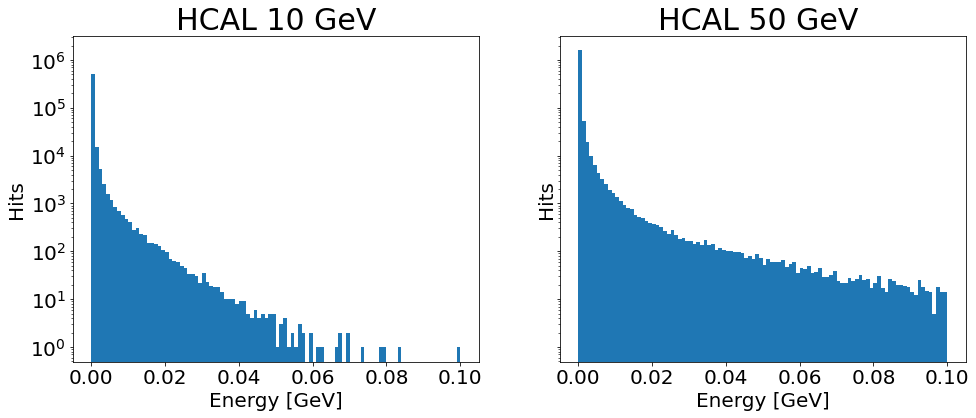

In [63]:
fig = plt.figure( figsize=(8, 6))
fig,ax = plt.subplots(1,2, figsize=(16, 6),sharex=True,sharey=True)
### This is tested and is energy 

MinRange=0.0
MaxRange=0.1
ax[0].hist(ak.flatten(arrays10PiM['HcalEndcapPInsertHits.energy']),bins=100, range=(MinRange,MaxRange),label='HCAL')


ax[1].hist(ak.flatten(arrays50PiM['HcalEndcapPInsertHits.energy']),bins=100, range=(MinRange,MaxRange),label='HCAL')


ax[0].set_title('HCAL 10 GeV')
ax[1].set_title('HCAL 50 GeV ')
ax[0].set_yscale('log')
ax[0].set_xlabel('Energy [GeV]')
ax[0].set_ylabel('Hits')

ax[1].set_xlabel('Energy [GeV]')
ax[1].set_ylabel('Hits')

plt.show()


## one dimensional histograms (z position) 

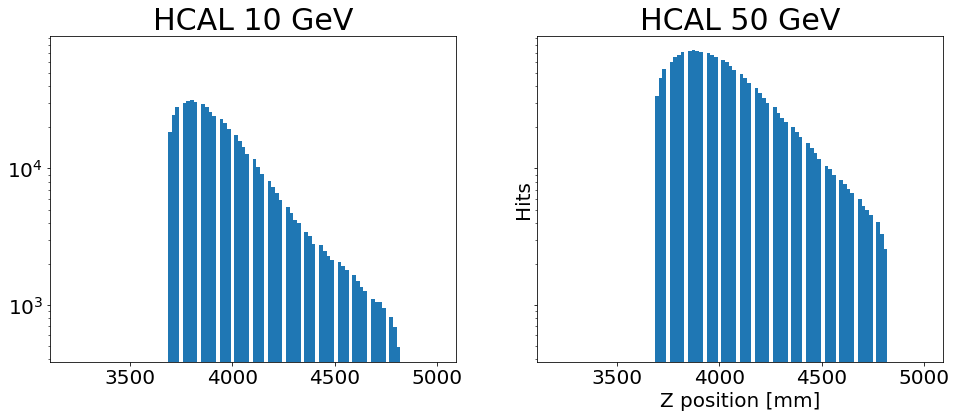

In [17]:
#fig = plt.figure( figsize=(8, 6))
fig,ax = plt.subplots(1,2, figsize=(16, 6),sharex=True,sharey=True)

MinRange=3200
MaxRange=5000
ax[0].hist(ak.flatten(arrays10PiM['HcalEndcapPInsertHits.position.z']),bins=100, range=(MinRange,MaxRange),label='HCAL')


ax[1].hist(ak.flatten(arrays50PiM['HcalEndcapPInsertHits.position.z']),bins=100, range=(MinRange,MaxRange),label='HCAL')


ax[0].set_title('HCAL 10 GeV')
ax[1].set_title('HCAL 50 GeV')
ax[0].set_yscale('log')
ax[1].set_xlabel('Z position [mm]')
ax[1].set_ylabel('Hits')

plt.show()


## one dimensiona histogram Y position

<Figure size 576x432 with 0 Axes>

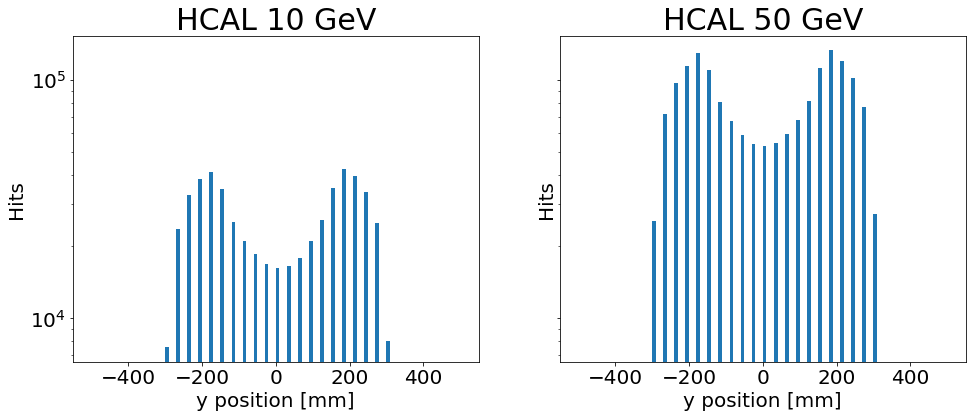

In [15]:
fig = plt.figure( figsize=(8, 6))
fig,ax = plt.subplots(1,2, figsize=(16, 6),sharex=True,sharey=True)
### This is tested and is energy 

MinRange=-500
MaxRange=500
ax[0].hist(ak.flatten(arrays10PiM['HcalEndcapPInsertHits.position.y']),bins=100, range=(MinRange,MaxRange),label='HCAL')


ax[1].hist(ak.flatten(arrays50PiM['HcalEndcapPInsertHits.position.y']),bins=100, range=(MinRange,MaxRange),label='HCAL')


ax[0].set_title('HCAL 10 GeV')
ax[1].set_title('HCAL 50 GeV')
ax[0].set_yscale('log')
ax[0].set_xlabel('y position [mm]')
ax[0].set_ylabel('Hits')

ax[1].set_xlabel('y position [mm]')
ax[1].set_ylabel('Hits')

plt.show()


## one dimensional X position

<Figure size 576x432 with 0 Axes>

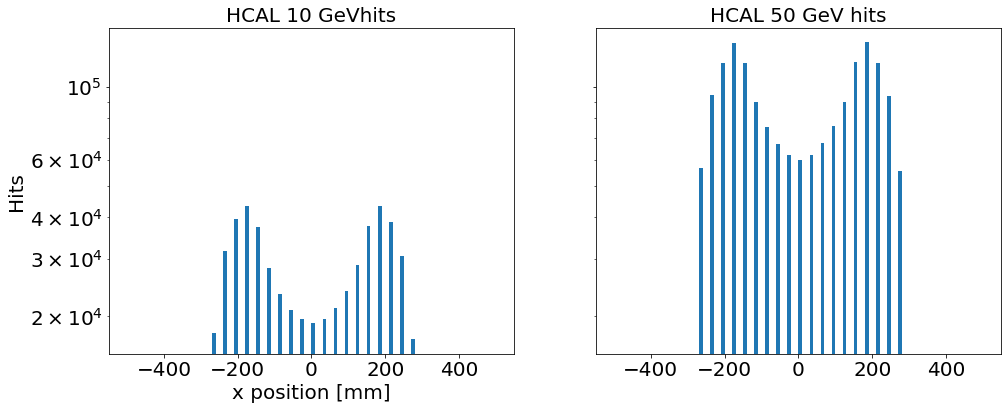

"\nfig = plt.figure( figsize=(8, 6))\nplt.hist(ak.flatten(arrays['HcalEndcapPInsertHits.position.x']),bins=100,range=(-500,500), label='HCAL')\nplt.yscale('log')\nplt.xlabel('X position [mm]')\nplt.ylabel('hits')\nplt.show()\n"

In [142]:
fig = plt.figure( figsize=(8, 6))
fig,ax = plt.subplots(1,2, figsize=(16, 6),sharex=True,sharey=True)
### This is tested and is energy 
ax[0].hist(ak.flatten(arrays10PiM['HcalEndcapPInsertHits.position.x']),bins=100, range=(-500,500),label='HCAL')


ax[1].hist(ak.flatten(arrays50PiM['HcalEndcapPInsertHits.position.x']),bins=100, range=(-500,500),label='HCAL')


ax[0].set_title('HCAL 10 GeVhits')
ax[1].set_title('HCAL 50 GeV hits')
ax[0].set_yscale('log')
ax[0].set_xlabel('x position [mm]')
ax[0].set_ylabel('Hits')

plt.show()


'''
fig = plt.figure( figsize=(8, 6))
plt.hist(ak.flatten(arrays['HcalEndcapPInsertHits.position.x']),bins=100,range=(-500,500), label='HCAL')
plt.yscale('log')
plt.xlabel('X position [mm]')
plt.ylabel('hits')
plt.show()
'''

## Two dimensional histograms

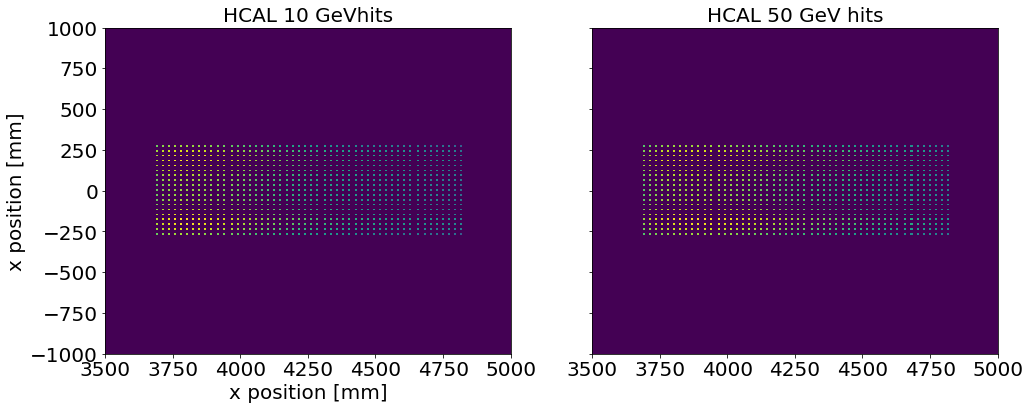

In [143]:
fig,ax = plt.subplots(1,2, figsize=(16, 6),sharex=True,sharey=True)
x10 = ak.flatten(arrays10PiM['HcalEndcapPInsertHits.position.z'])
y10 = ak.flatten(arrays10PiM['HcalEndcapPInsertHits.position.x'])
ax[0].hist2d(np.array(x10),np.array(y10),bins=200, range=([3500,5000],[-1000,1000]),norm=mcolors.PowerNorm(0.2))

x50 = ak.flatten(arrays50PiM['HcalEndcapPInsertHits.position.z'])
y50 = ak.flatten(arrays50PiM['HcalEndcapPInsertHits.position.x'])
ax[1].hist2d(np.array(x50),np.array(y50),bins=200, range=([3500,5000],[-1000,1000]),norm=mcolors.PowerNorm(0.2))

ax[0].set_title('HCAL 10 GeVhits')
ax[1].set_title('HCAL 50 GeV hits')
#ax[0].set_yscale('log')
ax[0].set_ylabel('x position [mm]')
ax[0].set_xlabel('x position [mm]')

#plt.xlabel('position z [mm]')
#plt.ylabel('Position x [mm]')
plt.show()


## Two dimensional image X vs Y

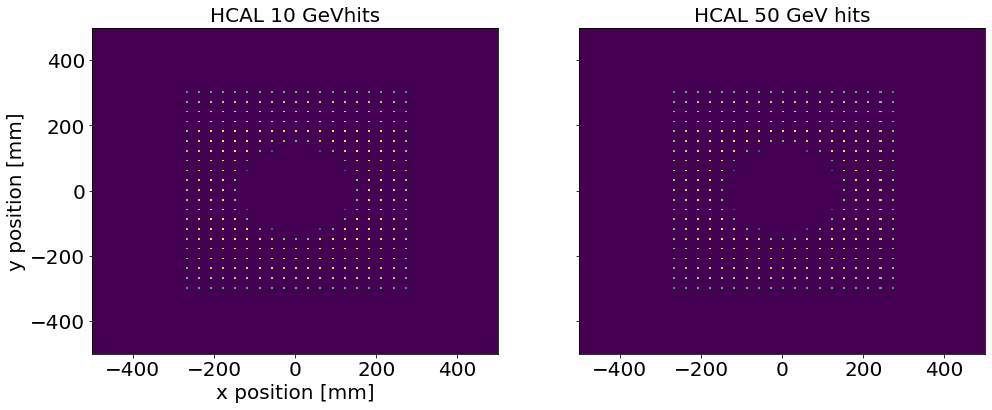

In [144]:
fig,ax = plt.subplots(1,2, figsize=(16, 6),sharex=True,sharey=True)
x10 = ak.flatten(arrays10PiM['HcalEndcapPInsertHits.position.x'])
y10 = ak.flatten(arrays10PiM['HcalEndcapPInsertHits.position.y'])
ax[0].hist2d(np.array(x10),np.array(y10),bins=200, range=([-500,500],[-500,500]),norm=mcolors.PowerNorm(0.2))

x50 = ak.flatten(arrays50PiM['HcalEndcapPInsertHits.position.x'])
y50 = ak.flatten(arrays50PiM['HcalEndcapPInsertHits.position.y'])
ax[1].hist2d(np.array(x50),np.array(y50),bins=200, range=([-500,500],[-500,500]),norm=mcolors.PowerNorm(0.2), )

ax[0].set_title('HCAL 10 GeVhits')
ax[1].set_title('HCAL 50 GeV hits')
#ax[0].set_yscale('log')
ax[0].set_xlabel('x position [mm]')
ax[0].set_ylabel('y position [mm]')
plt.show()

## Heat map in 

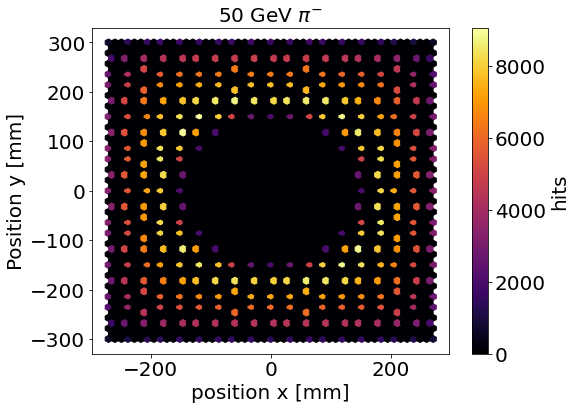

In [163]:
fig,ax = plt.subplots(1,1, figsize=(8, 6),sharex=True,sharey=True)
x50 = ak.flatten(arrays['HcalEndcapPInsertHits.position.x'])
y50 = ak.flatten(arrays['HcalEndcapPInsertHits.position.y'])


hb=ax.hexbin(np.array(x50),np.array(y50),gridsize=50, cmap='inferno')

cb = fig.colorbar(hb, label='hits')

plt.xlabel('position x [mm]')
plt.title("50 GeV $\pi^{-}$")

plt.ylabel('Position y [mm]')
plt.show()



## Simple 2D map without heat map

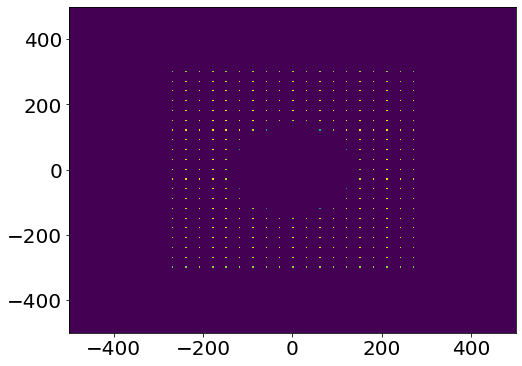

In [217]:
fig,ax = plt.subplots(1,1, figsize=(8, 6),sharex=True,sharey=True)
ax.hist2d(np.array(x),np.array(y),bins=300, range=([-500,500],[-500,500]),norm=mcolors.PowerNorm(0.1))
plt.show()

## Muon (-), [-3 -3] deg,  50 Gev

In [236]:
#FileNamemu50="endcapP_insert_50GeV_-3_3_muM.root"
FileNamemu50="endcapP_insert_50GeV_-3_3_muM.root"
events50muM=ur.open(f"{FilePath}{FileNamemu50}:events")
events50muM.keys()
arrays50muM = events50muM.arrays()

## x and y position

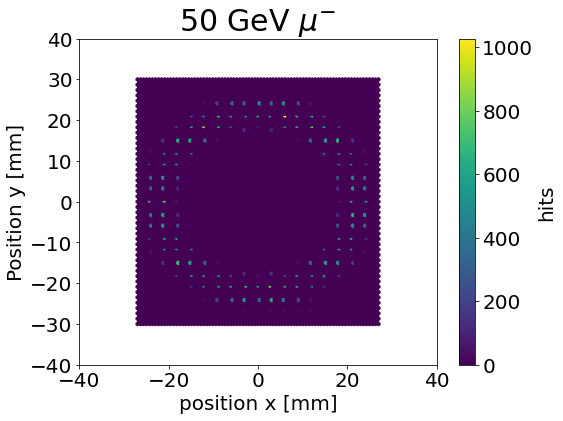

In [239]:
fig,ax = plt.subplots(1,1, figsize=(8, 6),sharex=True,sharey=True)
x50Mu = ak.flatten(arrays50muM['HcalEndcapPInsertHits.position.x'])/10.
y50Mu = ak.flatten(arrays50muM['HcalEndcapPInsertHits.position.y'])/10.

xlim=40

hb=ax.hexbin(np.array(x50Mu),np.array(y50Mu), gridsize=80, cmap='viridis') 
#viridis, inferno

cb = fig.colorbar(hb, label='hits', ax=ax)

plt.xlabel('position x [mm]')
plt.title("50 GeV $\mu^{-}$")


ax.set_xlim(-xlim,xlim)
ax.set_ylim(-xlim,xlim)

plt.ylabel('Position y [mm]')

plt.show()



## Plot z vs x,y

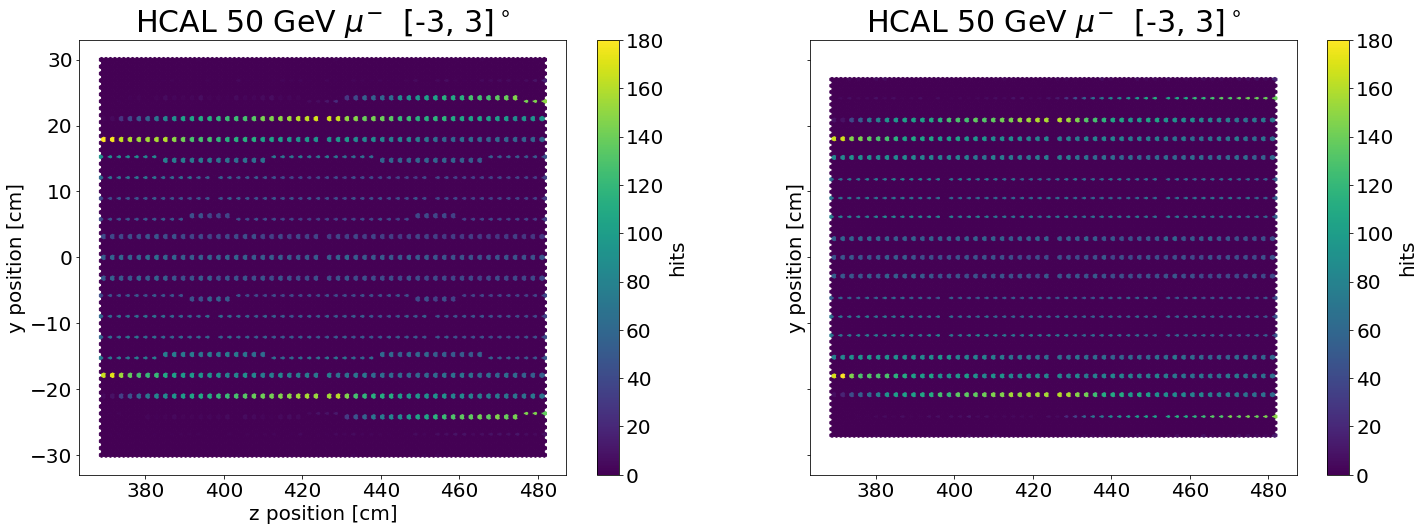

In [214]:
fig,ax = plt.subplots(1,2, figsize=(24, 8),sharex=True,sharey=True)
to_cm=10.0;
nbins=50
z50mu = ak.flatten(arrays50muM['HcalEndcapPInsertHits.position.z'])/to_cm
y50mu = ak.flatten(arrays50muM['HcalEndcapPInsertHits.position.y'])/to_cm
x50mu = ak.flatten(arrays50muM['HcalEndcapPInsertHits.position.x'])/to_cm
#ax[0].hist2d(np.array(z50mu),np.array(y50mu),bins=nbins, range=([340,500],[-xlim,xlim]),norm=mcolors.PowerNorm(0.2))
#ax[1].hist2d(np.array(z50mu),np.array(x50mu),bins=nbins, range=([350,500],[-xlim,xlim]),norm=mcolors.PowerNorm(0.2))


hb=ax[0].hexbin(np.array(z50mu),np.array(y50mu), gridsize=100, cmap='viridis') 
hb=ax[1].hexbin(np.array(z50mu),np.array(x50mu), gridsize=100, cmap='viridis') 
#viridis, inferno

cb = fig.colorbar(hb,  ax=ax[0], label='hits')


cb = fig.colorbar(hb,  ax=ax[1], label='hits')
ax[0].set_title('HCAL 50 GeV $\mu^{-}$  [-3, 3]$^\circ$')
ax[1].set_title('HCAL 50 GeV $\mu^{-}$  [-3, 3]$^\circ$')
#ax[0].set_yscale('log')
ax[0].set_ylabel('y position [cm]')
ax[0].set_xlabel('z position [cm]')
ax[1].set_ylabel('y position [cm]')

plt.show()

### Energy analysis For muon Energy Resolution

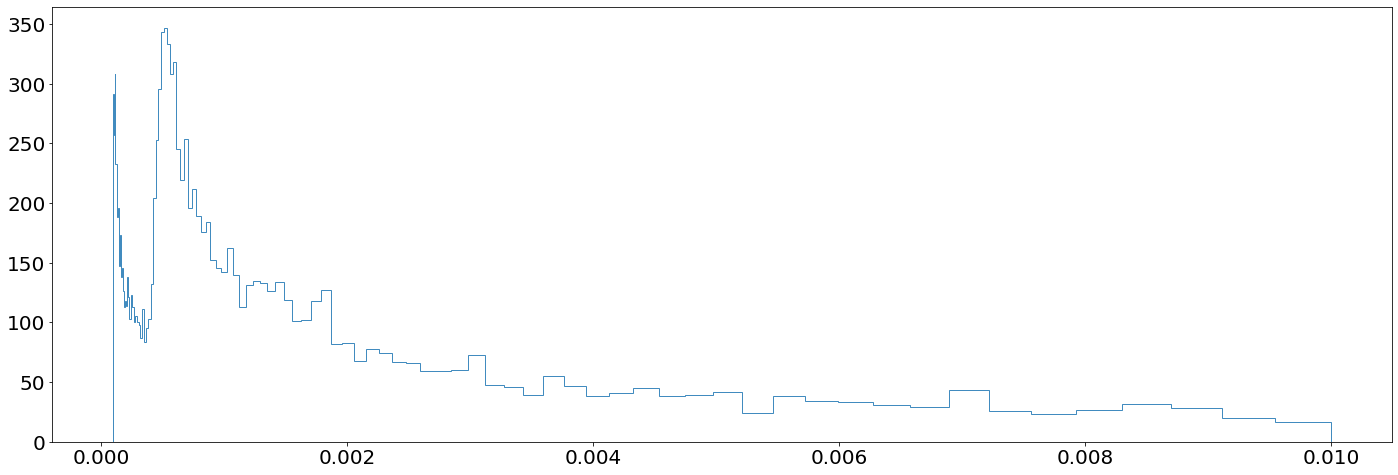

In [33]:
FilePath="/home/bishnu/EIC/Data/"
#FileName10="endcapP_insert_10GeV_177_177_muM.root"
#FileName50="endcapP_insert_50GeV_177_177_muM.root"
FileName100="rec_cal_output_99-100_3deg.edm4hep.root"#"endcapP_insert_100GeV_177_177_muM.root"
'''
events10=ur.open(f"{FilePath}{FileName10}:events")
events10.keys()
arrays10 = events10.arrays()


events50=ur.open(f"{FilePath}{FileName50}:events")
events50.keys()
arrays50 = events50.arrays()
'''
events100=ur.open(f"{FilePath}{FileName100}:events")
events100.keys()
arrays100 = events100.arrays()




fig,ax = plt.subplots(1,1, figsize=(24, 8),sharex=True,sharey=True)

#ax.hist(ak.flatten(arrays10['HcalEndcapPInsertHits.energy']),bins=100, range=(0,0.05),label='HCAL',color='r',histtype='step')
#ax.hist(ak.flatten(arrays50['HcalEndcapPInsertHits.energy']),bins=100, range=(0,0.05),label='HCAL',color='b',histtype='step')
#ax.hist(ak.flatten(arrays100['HcalEndcapPInsertHits.energy']),bins=100, range=(0,0.05),label='HCAL',color='g',histtype='step')
#ax.set_yscale('log')

plt.hist(ak.flatten(arrays100['HcalEndcapPInsertHitsReco.energy']),bins=np.geomspace(0.0001,0.01,100),label='ECAL',alpha=0.85,histtype='step')
plt.show()

total HCAL energy [0.383, 0, 0, 0, 0, 0, 0, 0, 0.534, 0, ... 0, 0, 0.523, 0.327, 0, 0, 0.461, 0, 0.57]
Average hit energy in HCAL [0.000455, None, None, None, None, None, ... None, None, 0.000317, None, 0.000603]


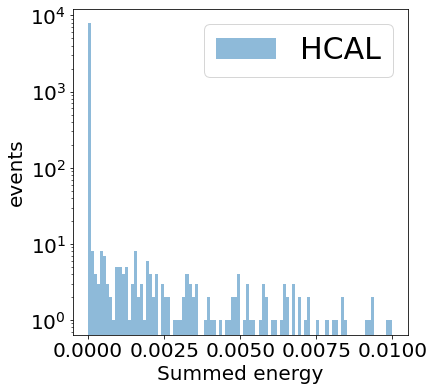

In [232]:
HCALhits = arrays100['HcalEndcapPInsertHitsReco.energy'][:,:]
mask = HCALhits<1e10
HCALhits = HCALhits[mask]
HCAL_total = ak.sum(HCALhits,axis=-1)
HCAL_average = ak.mean(HCALhits,axis=-1)
HCAL_nhits = ak.num(HCALhits)

print('total HCAL energy' , HCAL_total)
print('Average hit energy in HCAL' , HCAL_average)


fig = plt.figure( figsize=(6, 6))

plt.hist(HCAL_total,bins=100,alpha=0.5,range=(0,0.010),label='HCAL')

plt.xlabel('Summed energy')
plt.ylabel('events')
plt.legend()
plt.yscale('log')

plt.show()

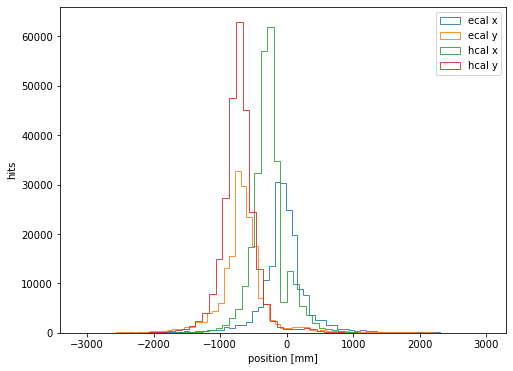

In [10]:
fig = plt.figure( figsize=(8, 6))
plt.hist(ak.flatten(arrays['EcalEndcapPHitsReco.local.x']),bins=60,label='ecal x',alpha=0.85,histtype='step')
plt.hist(ak.flatten(arrays['EcalEndcapPHitsReco.local.y']),bins=60, label='ecal y',alpha=0.85,histtype='step')
plt.hist(ak.flatten(arrays['HcalEndcapPHitsReco.local.x']),bins=60,label='hcal x',alpha=0.85,histtype='step')
plt.hist(ak.flatten(arrays['HcalEndcapPHitsReco.local.y']),bins=60, label='hcal y',alpha=0.85,histtype='step')
plt.legend()
#plt.yscale('log')
plt.xlabel('position [mm]')
plt.ylabel('hits')
plt.show()

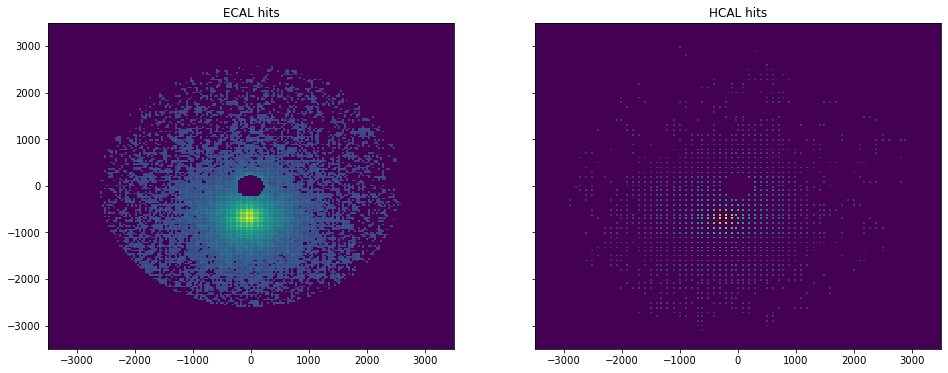

In [11]:
fig,ax = plt.subplots(1,2, figsize=(16, 6),sharex=True,sharey=True)
x = ak.flatten(arrays['EcalEndcapPHitsReco.local.x'])
y = ak.flatten(arrays['EcalEndcapPHitsReco.local.y'])
ax[0].hist2d(np.array(x),np.array(y),bins=200, range=([-3500,3500],[-3500,3500]),norm=mcolors.PowerNorm(0.2))

x = ak.flatten(arrays['HcalEndcapPHitsReco.local.x'])
y = ak.flatten(arrays['HcalEndcapPHitsReco.local.y'])
ax[1].hist2d(np.array(x),np.array(y),bins=200, range=([-3500,3500],[-3500,3500]),norm=mcolors.PowerNorm(0.2))


ax[1].set_title('HCAL hits')
ax[0].set_title('ECAL hits')

plt.show()

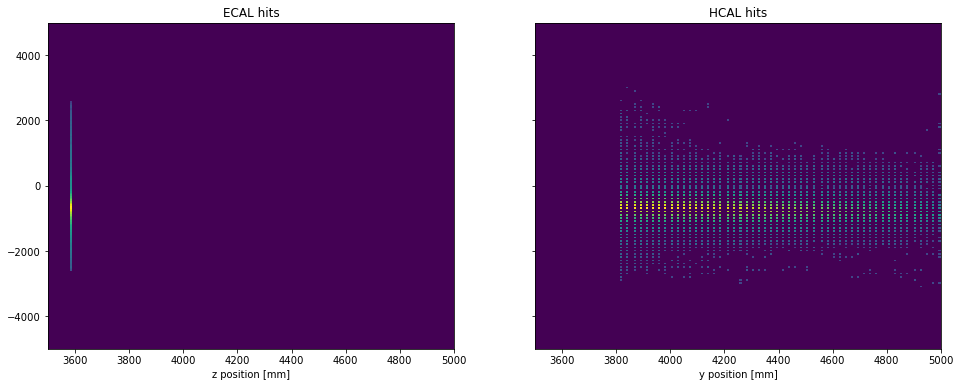

In [21]:
fig,ax = plt.subplots(1,2, figsize=(16, 6),sharex=True,sharey=True)
x = ak.flatten(arrays['EcalEndcapPHitsReco.position.z'])
y = ak.flatten(arrays['EcalEndcapPHitsReco.local.y'])
ax[0].hist2d(np.array(x),np.array(y),bins=200, range=([3500,5000],[-5000,5000]),norm=mcolors.PowerNorm(0.2))

x = ak.flatten(arrays['HcalEndcapPHitsReco.position.z'])
y = ak.flatten(arrays['HcalEndcapPHitsReco.local.y'])
ax[1].hist2d(np.array(x),np.array(y),bins=200, range=([3500,5000],[-5000,5000]),norm=mcolors.PowerNorm(0.2))


ax[0].set_xlabel('z position [mm]')
ax[1].set_xlabel('y position [mm]')

ax[1].set_title('HCAL hits')
ax[0].set_title('ECAL hits')

plt.show()

## Hit energy distributions

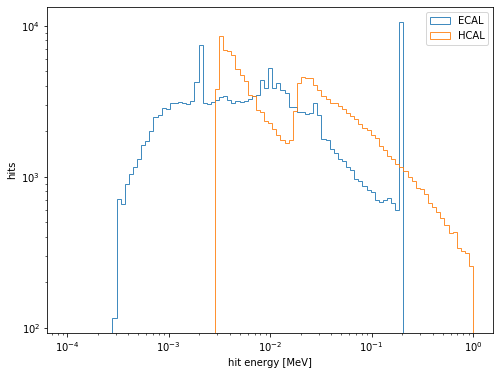

In [52]:
fig = plt.figure( figsize=(8, 6))
plt.hist(ak.flatten(arrays['EcalEndcapPHitsReco.energy']),bins=np.geomspace(0.0001,1,100),label='ECAL',alpha=0.85,histtype='step')
plt.hist(ak.flatten(arrays['HcalEndcapPHitsReco.energy']),bins=np.geomspace(0.0001,1,100), label='HCAL',alpha=0.85,histtype='step')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylabel('hits')
plt.xlabel('hit energy [MeV]')
plt.show()

In [90]:
HCALhits = arrays['HcalEndcapPHitsReco.energy'][:,:]
mask = HCALhits<1e10
HCALhits = HCALhits[mask]
HCAL_total = ak.sum(HCALhits,axis=-1)
HCAL_average = ak.mean(HCALhits,axis=-1)
HCAL_nhits = ak.num(HCALhits)

print('total HCAL energy' , HCAL_total)
print('Average hit energy in HCAL' , HCAL_average)


ECALhits = arrays['EcalEndcapPHitsReco.energy'][:,:]
mask = ECALhits<1e10
ECALhits = ECALhits[mask]
ECAL_total = ak.sum(ECALhits,axis=-1)
ECAL_average = ak.mean(ECALhits,axis=-1)
ECAL_nhits = ak.num(ECALhits)

print('total ECAL energy' , ECAL_total)
print('Average hit energy in ECAL' , ECAL_average)

total HCAL energy [4.63, 15.8, 15, 7.77, 5.09, 14.1, 16.6, ... 3.86, 5.02, 10.1, 1.9, 13.6, 7.67, 14.1]
Average hit energy in HCAL [0.0336, 0.0692, 0.0561, 0.0835, 0.0382, ... 0.0538, 0.0365, 0.0723, 0.0502, 0.0468]
total ECAL energy [19, 0.484, 0.714, 0.434, 5.58, 5.41, 1.39, ... 10.2, 6.22, 7.57, 2.6, 6.69, 0.533]
Average hit energy in ECAL [0.0409, 0.0403, 0.0193, 0.0542, 0.0239, ... 0.0208, 0.0394, 0.0163, 0.0352, 0.0222]


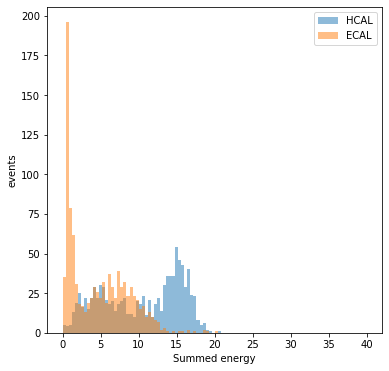

In [91]:
fig = plt.figure( figsize=(6, 6))

plt.hist(HCAL_total,bins=100,alpha=0.5,range=(0,40),label='HCAL')
plt.hist(ECAL_total,bins=100,alpha=0.5,range=(0,40),label='ECAL')

plt.xlabel('Summed energy')
plt.ylabel('events')
plt.legend()

plt.show()


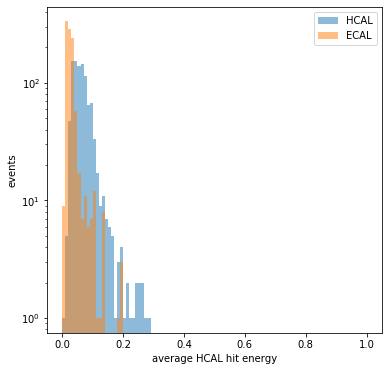

In [93]:
fig = plt.figure( figsize=(6, 6))

plt.hist(HCAL_average,bins=100,alpha=0.5,range=(0,1),label='HCAL')
plt.hist(ECAL_average,bins=100,alpha=0.5,range=(0,1),label='ECAL')

plt.xlabel('average HCAL hit energy')
plt.ylabel('events')
plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.show()


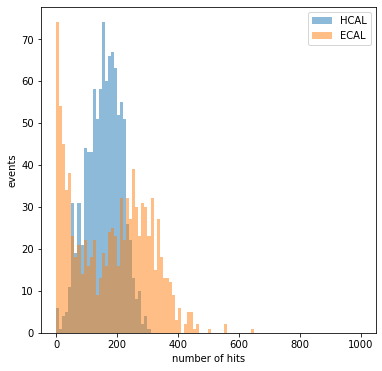

In [100]:
fig = plt.figure( figsize=(6, 6))

plt.hist(HCAL_nhits,bins=100,alpha=0.5,range=(0,1000),label='HCAL')
plt.hist(ECAL_nhits,bins=100,alpha=0.5,range=(0,1000),label='ECAL')

plt.xlabel('number of hits')
plt.ylabel('events')
#plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.show()


In [ ]:
pz = ak.to_numpy(arrays['MCParticles.momentum.z'][:,-1])
py = ak.to_numpy(arrays['MCParticles.momentum.y'][:,-1])
px = ak.to_numpy(arrays['MCParticles.momentum.x'][:,-1])
mass = ak.to_numpy(arrays['MCParticles.mass'][:,-1])
p = np.sqrt(px*px + py*py+ pz*pz)
gen_E = np.sqrt(p*p + mass*mass)-mass

In [ ]:
fig = plt.figure( figsize=(8, 6))

plt.hist(p,range=(0,100),bins=100,alpha=0.5)
#plt.hist(gen_E,range=(0,100),bins=100,alpha=0.5)

plt.xlabel('generated momentum [GeV]')
plt.ylabel('entries')
plt.show()
print(len(p))

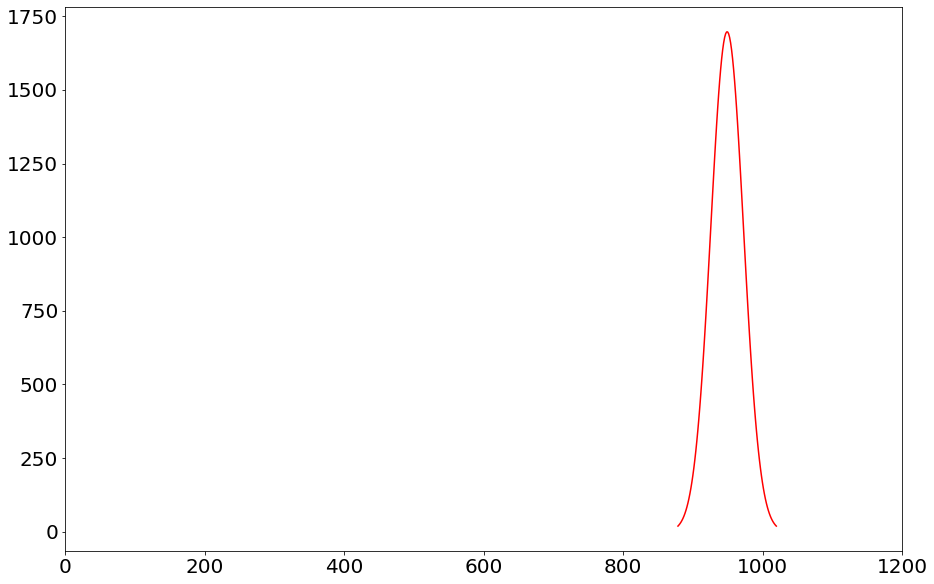

23.5


In [12]:
import scipy.stats as stats
import math

mux =949
sigma =23.5# math.sqrt(variance)
x = np.linspace(mux - 3*sigma, mux + 3*sigma, 100)
#y = np.linspace(muy - 3*sigma, muy + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mux, sigma)*1e5, color='r')
plt.xlim(0,1200)
#plt.plot(y, stats.norm.pdf(y, muy, sigma), color='b')
plt.show()
print(sigma)

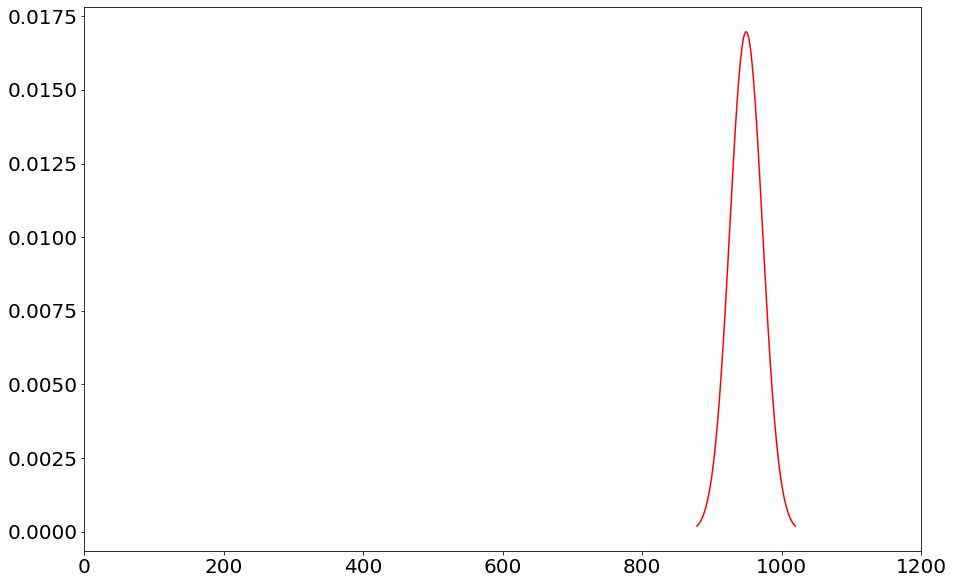

23.5


In [14]:
mux =949
sigma =23.5# math.sqrt(variance)
x = np.linspace(mux - 3*sigma, mux + 3*sigma, 100)
#y = np.linspace(muy - 3*sigma, muy + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mux, sigma), color='r')
plt.xlim(0,1200)
#plt.plot(y, stats.norm.pdf(y, muy, sigma), color='b')
plt.show()
print(sigma)


In [96]:
import math
theta_to_rad=math.pi/180.
thetas=np.array([2.32,2.56,2.83,3.13,3.46,3.82,4.23])
etas=np.array([3.9,3.8,3.7,3.6,3.5,3.4,3.3])
minus_theta=180-thetas
theta_rad_half=np.sin(thetas*theta_to_rad/2.0)

calc_etas=np.log(theta_rad_half)*-1.0

diff_eta=calc_etas-etas
np.set_printoptions(precision=2)
print(diff_eta)  

[-0.  0.  0.  0.  0.  0. -0.]


array([3, 3])

In [86]:
b.sum(axis=1)

array([2, 4])

In [87]:
b.sum(axis=-1)

array([2, 4])

In [16]:
x=60/0.0175
print(x)

3428.5714285714284
